In [1]:
# Basic utilities and data handling
import numpy as np
import pandas as pd
import time
import ast
pd.set_option('display.max_columns', None)  # Display all columns in DataFrame outputs

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Imputation of missing entries
import miceforest

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix 
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

# Model interpretation
import shap

# Suppress some warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored")
warnings.filterwarnings('ignore', category=UserWarning, message='.*deprecated binary model format.*')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Introduction

### Overview

The Starbucks Capstone Challenge involves the exploration and analysis of a dataset that mimics customer behavior on the Starbucks rewards mobile app. This dataset provides a detailed view of customer interactions with various promotional offers, alongside demographic insights and transaction records. Through this data, we can dissect how customers respond to different promotional strategies deployed by Starbucks, which aids in refining future marketing campaigns.

### Data Description

The dataset includes one month of simulated customer data, including their demographics, transactions, and interactions with promotional offers. Each person in the simulation has hidden traits that influence their purchasing patterns, and that are associated with their observable traits.

The dataset consists of three separate files:

- **portfolio.json** - This file contains details about each promotional offer.
  - `reward`: the monetary value of the offer.
  - `channels`: the way the offer was distributed. This can be a combination of web, email, mobile, and social media.
  - `difficulty`: the amount the customer needs to spend in order to receive the reward.
  - `duration`: the total number of days the offer was available for.
  - `offer_type`: the type of the offer. This is either a money-off offer (discount), buy-one-get-one-free (bogo) or a newsletter (informational).
  - `id`: the offer identification.

- **profile.json** - This file contains demographic information about the customers.
  - `gender`: the identified gender of the customer.
  - `age`: the age of the customer at the time of the promotion period.
  - `id`: the customer membership identification.
  - `became_member_on`: the date when the customer became a member.
  - `income`: the self-reported income of the customer at the time of the promotion period.
  
- **transcript.json** - This file contains records of the transactions of the customers across the promotion period. 
  - `person`: the customer membership identification.
  - `event`: the event. This is either offer received, offer viewed, offer complete or transaction.
  - `value["offer id"]`: the offer identification.
  - `value["amount"]`: the amount spent for a given transaction.
  - `value["reward"]`: the monetary value received from the offer.
  - `time`: the time from the beginning of the promotion period (in hours).

### Challenges

The dataset presents several challenges:

- **Data Quality and Integrity**: Issues such as missing values or inconsistencies across different files need addressing to ensure the integrity of the analysis.

- **Complexity in Data Manipulation**: Data from multiple sources (portfolio, profile, transcript) requires careful manipulation to align customer actions and demographics effectively.

- **High Dimensionality**: The presence of multiple dimensions in the data, due to various attributes associated with offers, demographics, and transactions, demands meticulous feature engineering and exploration.

### Project Objectives

The objectives of this project are structured to enhance data usability and derive actionable insights:

- **Data Processing**: Each dataset (profile, portfolio, transcript) is individually processed to correct missing values and inconsistencies. This includes merging specific features from one dataset to another to enhance the analytical value of the data.

- **Feature Engineering**: New and valuable features are engineered within each dataset to enrich the analysis.

- **Exploratory Data Analysis (EDA)**: A thorough exploration of the datasets is conducted to uncover patterns in customer behavior, the effectiveness of different offer types, and demographic influences on offer reception and transaction behaviors.

- **Predictive Modelling**: Predictive models are developed to:
   - Estimate the average transaction size based on customer demographics.
   - Predict whether a customer will view an offer, considering their demographics and the channels through which the offer is distributed.
   - Predict whether an offer will successfully attract completion, factoring in customer demographics and offer details.

## Data Processing

### Profile Data

**Initial Data Examination**

Before diving into data manipulation, it's crucial to understand the structure and content of the data we're working with. The initial step is to load and display the `profile` dataset, which contains demographic information about the customers.

In [2]:
# Load the profile data and display the first few rows for an overview
profile = pd.read_csv('starbucks_data/profile.csv', index_col=0)
display(profile)

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


**Visualizing Data Distributions**

To better understand each feature in our dataset, we use visualizations. Visual analysis can immediately highlight distributions, tendencies, and potential anomalies in the data.

In [3]:
# Function to visualize each column in the DataFrame using appropriate plot types based on the data type.
def plot_all_columns(df):
    num_columns = len(df.columns)
    fig, axes = plt.subplots(nrows=num_columns, figsize=(6, num_columns * 4))
    if num_columns == 1:
        axes = [axes]

    for ax, col in zip(axes, df.columns):
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(data=df, x=col, ax=ax, bins=40)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            sns.lineplot(data=df, x=col, y=df.select_dtypes(include=['number']).columns[0], ax=ax)
        else:
            sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Plot for {col}')
        rotate_labels_if_needed(ax)

    plt.tight_layout()
    plt.show()


# Function to rotate axis labels if they are too long and overlap.
def rotate_labels_if_needed(ax, rotation_threshold=1, rotation_angle=30):
    fig = plt.gcf()
    renderer = fig.canvas.get_renderer()
    max_label_width = max(t.get_window_extent(renderer).width for t in ax.get_xticklabels())
    available_space = ax.get_window_extent(renderer).width / len(ax.get_xticklabels())
    
    if max_label_width > available_space * rotation_threshold:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_angle, ha='right')

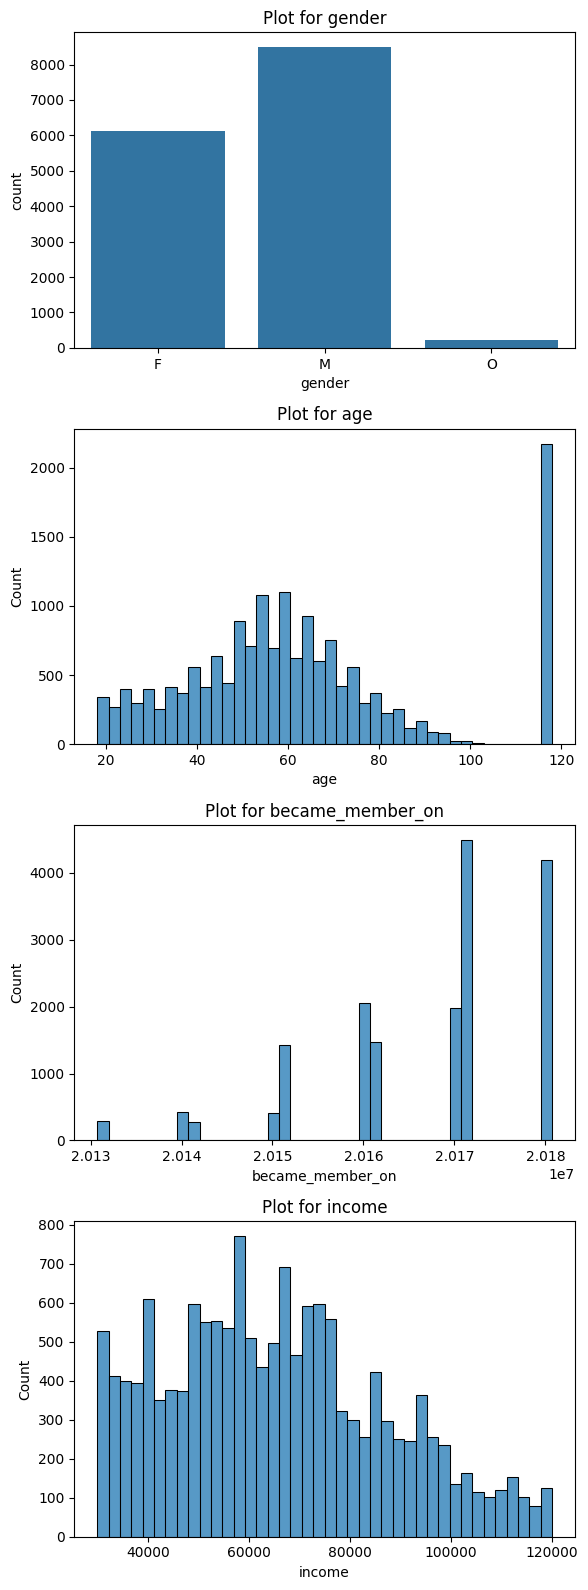

In [4]:
# Visualize the distribution of features
plot_all_columns(profile.drop('id', axis=1))

**Addressing Data Anomalies**

Upon visualizing the data, a notable anomaly was observed in the `age` feature—a large spike at age 118, which appears to be a placeholder for missing values. This is addressed by replacing these values with `NaN`.

In [5]:
# Handle missing age values represented by '118'
profile['age'] = profile['age'].replace(118, np.nan)
display(profile)

,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


**Feature Engineering**

Enhancing the dataset with additional meaningful features is crucial for more nuanced insights. Here, we calculate the number of days each customer has been a member for.

In [6]:
# Convert 'became_member_on' from an integer to datetime format and compute membership duration
profile['date'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
time_of_study = pd.Timestamp('2018-09-01')  # assumed date of study
profile['member_days'] = (time_of_study - profile['date']).dt.days
profile.drop(['became_member_on'], axis=1, inplace=True)

**Final Data Overview and Visualization**

After processing and feature engineering, it’s beneficial to revisit the dataset and its feature distributions.

In [7]:
# Display the final structure and content of the profile data
display(profile)

,gender,age,id,income,date,member_days
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,566
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,413
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,51
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,480
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,393
...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018-06-04,89
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018-07-13,50
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,2017-01-26,583
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016-03-07,908


**Final Visualization**

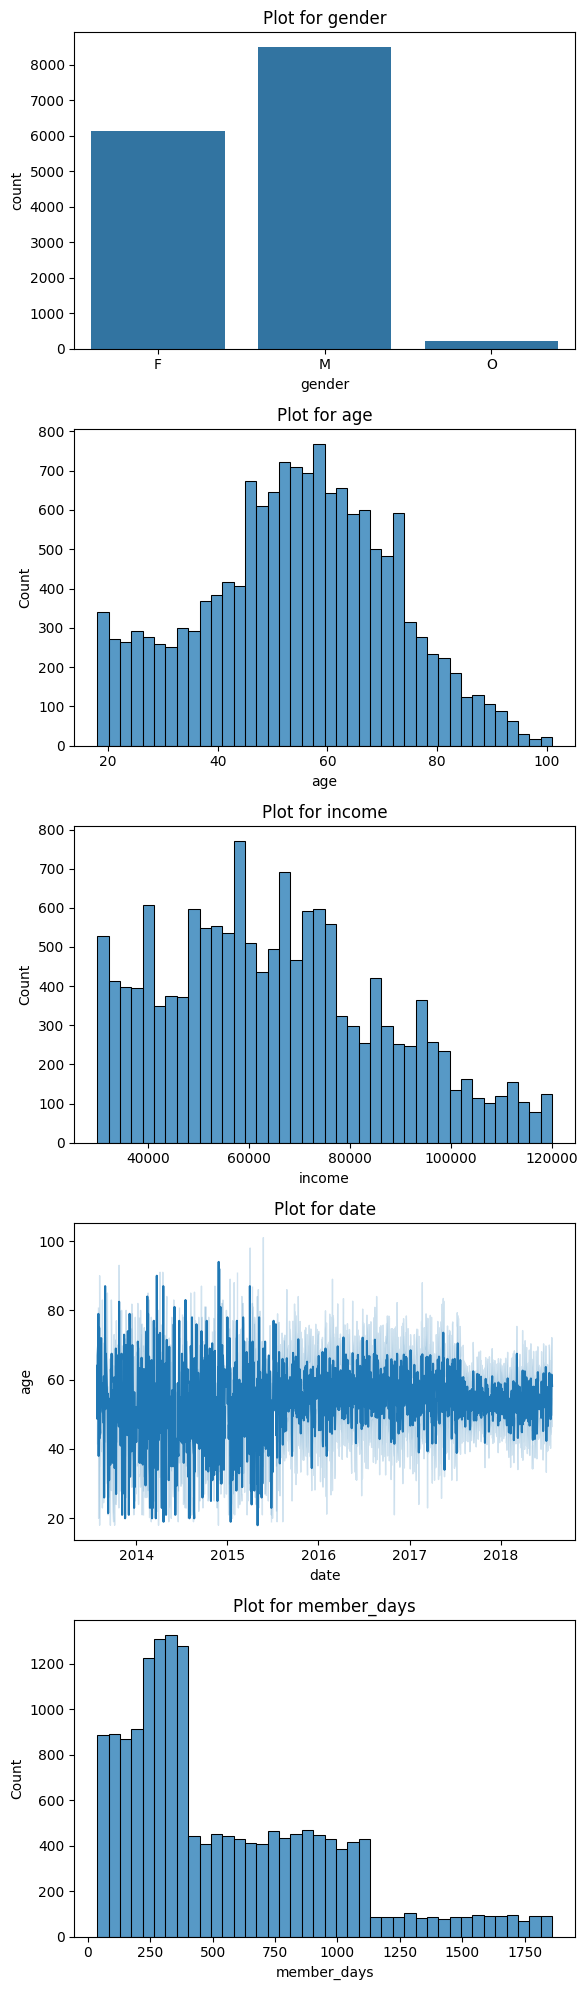

In [8]:
# Visualize the final feature distributions
plot_all_columns(profile.drop('id', axis=1))

### Portfolio Data

**Initial Data Examination**

To begin with, we load and examine the `portfolio` dataset, which includes details about the promotional offers such as type, duration, and reward.

In [9]:
# Load the portfolio data and display the first few rows to understand the structure and content
portfolio = pd.read_csv('starbucks_data/portfolio.csv', index_col=0)
display(portfolio)

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Simplifying Offer IDs**

The IDs in the dataset are lengthy and not immediately informative. Simplifying these IDs can make the dataset more accessible and easier to reference throughout the analysis.

In [10]:
# Simplify the offer IDs to be shorter and more descriptive, using the initial of the offer type
portfolio['offer_initial'] = portfolio['offer_type'].apply(lambda x: x[0].upper())

# Generate a new, more informative ID for each offer by combining the offer type initial with a sequential number
portfolio['new_id'] = portfolio.groupby('offer_initial').cumcount() + 1
portfolio['new_id'] = portfolio['offer_initial'] + portfolio['new_id'].astype(str)

# Map old IDs to new IDs and update the dataset
id_mapping = dict(zip(portfolio['id'], portfolio['new_id']))
portfolio['id'] = portfolio['new_id']
portfolio.drop(columns=['offer_initial', 'new_id'], inplace=True)
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

display(portfolio)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,B1
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,B2
2,0,"['web', 'email', 'mobile']",0,4,informational,I1
3,5,"['web', 'email', 'mobile']",5,7,bogo,B3
4,5,"['web', 'email']",20,10,discount,D1
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,D2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,D3
7,0,"['email', 'mobile', 'social']",0,3,informational,I2
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,B4
9,2,"['web', 'email', 'mobile']",10,7,discount,D4


**Visualizing Data Distributions**

Visualizing the distributions of key features in the `portfolio` dataset, such as offer duration, difficulty, and reward, helps in understanding the range and spread of promotional strategies Starbucks employs. Since `channels` is a list and not a single value, we exclude it from this visualization to focus on numeric and categorical data.

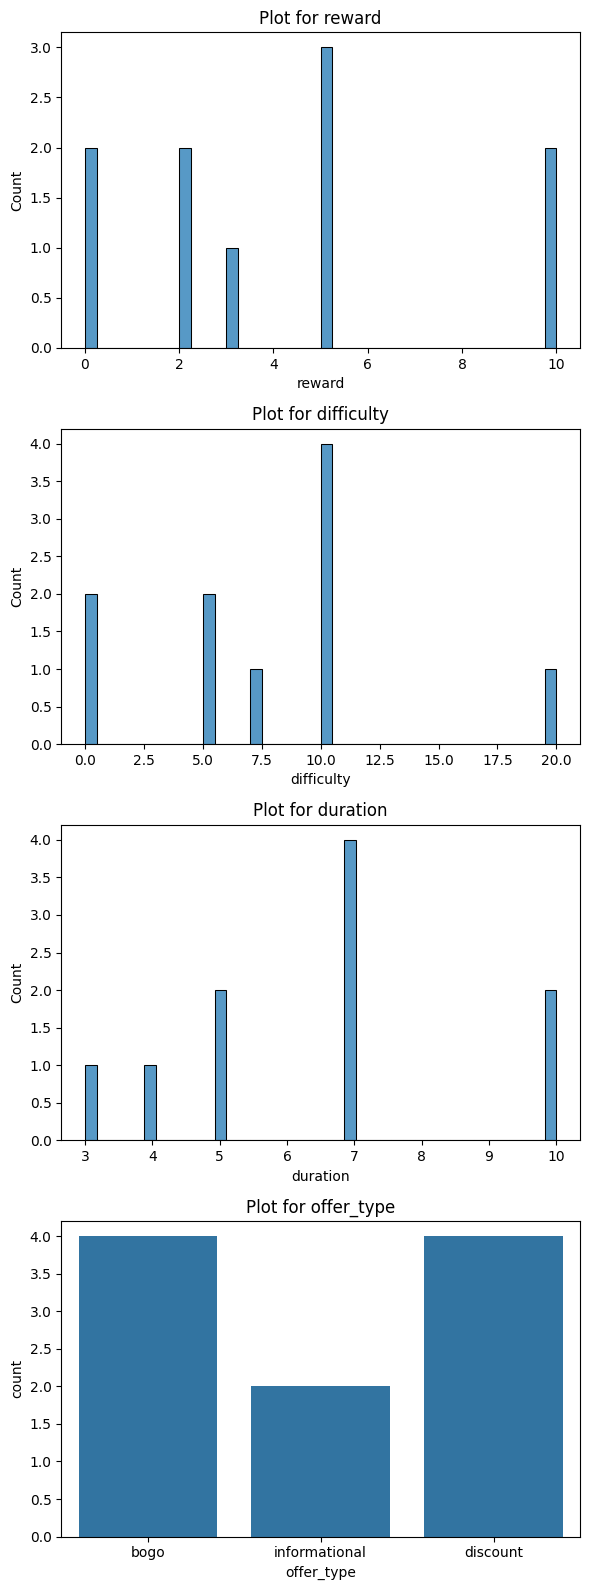

In [11]:
# Visualize the distribution of features
plot_all_columns(portfolio.drop(['offer_id', 'channels'], axis=1))

### Transcript Data

**Initial Data Examination**

To start, we load and examine the `transcript` dataset, which logs the actions taken by customers during the marketing experiment, such as receiving offers, viewing them, and making transactions.

In [12]:
# Load the transcript data and display the first few rows to understand the structure and content
transcript = pd.read_csv('starbucks_data/transcript.csv', index_col=0)
display(transcript)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [13]:
# Calculate and print the duration of the experiment in days
print(f'The experiment was run for {transcript["time"].max()/24} days.')

The experiment was run for 29.75 days.


**Cleaning the `value` Column**

The `value` column contains mixed types of data encapsulated in dictionary-like strings. We inspect this column to rectify potential inconsistencies in the dictionary keys.

In [14]:
# Utility function to extract unique keys from the 'value' column dictionaries
def get_value_keys(df, col):
    unique_keys = set()
    df[col].apply(lambda d: unique_keys.update(d.keys()))
    return list(unique_keys)

# Convert string representations of dictionaries in 'value' to actual dictionary objects
transcript['value'] = transcript['value'].apply(ast.literal_eval)

# Print initial unique keys found in 'value'
print(f'Value keys initially: {get_value_keys(transcript, "value")}')

# Function to correct inconsistencies in the 'value' keys
def correct_key(row):
    if 'offer id' in row:
        row['offer_id'] = row.pop('offer id')
    return row

# Apply corrections and confirm the changes
transcript['value'] = transcript['value'].apply(correct_key)
print(f'Value keys corrected: {get_value_keys(transcript, "value")}')

Value keys initially: ['offer_id', 'reward', 'offer id', 'amount']
Value keys corrected: ['offer_id', 'reward', 'amount']


**Unraveling the `value` Column**

To facilitate detailed analysis, we separate the information contained in the `value` column into distinct columns, enhancing data accessibility.

In [15]:
# Unravel the 'value' column into separate columns for each key
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id', None))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', None))
transcript.drop(['value'], axis=1, inplace=True)

display(transcript)

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53


**Mapping and Merging Offer Details**

Integrating refined `offer_id` data from the `portfolio` dataset to enrich the `transcript` data with offer details such as type, difficulty, and duration.

In [16]:
# Map the simplified offer_id and merge relevant offer details from 'portfolio'
transcript['offer_id'] = transcript['offer_id'].map(id_mapping)
transcript = transcript.merge(portfolio[['offer_id', 'offer_type', 'difficulty', 'duration']], on='offer_id', how='left')

display(transcript)

,person,event,time,offer_id,amount,offer_type,difficulty,duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,B3,NaN,bogo,5.0,7.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,D1,NaN,discount,20.0,10.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,D4,NaN,discount,10.0,7.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,D3,NaN,discount,10.0,10.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,B2,NaN,bogo,10.0,5.0
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN,NaN


**Advanced Data Engineering**

**Preparing Event and Transaction Data Subsets**

The initial step involves segmenting the `transcript` data into distinct subsets based on the type of event: offers received, offers viewed, offers completed, and transactions. This organization facilitates targeted analysis and manipulation of each event type.

In [17]:
# Segment the transcript data into different events for easier manipulation
offers_received = transcript.query('event == "offer received"')[['person', 'offer_id', 'time', 'difficulty', 'duration', 'offer_type']]
offers_viewed = transcript.query('event == "offer viewed"')[['person', 'offer_id', 'time']]
offers_completed = transcript.query('event == "offer completed"')[['person', 'offer_id', 'time']]
transactions = transcript.query('event == "transaction"')[['person', 'time', 'amount']]

display(offers_received)

,person,offer_id,time,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,B3,0,5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,D1,0,20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,D4,0,10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,0,10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,B2,0,10.0,5.0,bogo
...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,B1,576,10.0,7.0,bogo
257883,cb23b66c56f64b109d673d5e56574529,D4,576,10.0,7.0,discount
257884,6d5f3a774f3d4714ab0c092238f3a1d7,D2,576,7.0,7.0,discount
257885,9dc1421481194dcd9400aec7c9ae6366,B1,576,10.0,7.0,bogo


**Aligning Offer Events: Receiving, Viewing, and Completing**

Integrating data across different stages of the offer lifecycle (received, viewed, completed) for each customer is crucial for understanding the effectiveness of marketing strategies. This involves complex data manipulations to align events correctly, especially when customers receive the same offer multiple times.

In [18]:
# Merge offers received with offers viewed, aligning times and ensuring correct order
responses_v0 = offers_received.merge(offers_viewed, on=['person', 'offer_id'], suffixes=('_received', '_viewed'), how='left')
responses_v0 = responses_v0.merge(responses_v0.groupby(['person', 'offer_id']).apply(lambda x: x['time_received'].unique()).reset_index(), on=['person', 'offer_id'], how='left')
responses_v0.rename(columns={0: 'times_received'}, inplace=True)

# Function to ensure the times are aligned correctly
def align_event_column(row, event_time_column):
    times_received = row['times_received'].tolist()
    if row[event_time_column] < row['time_received']:
        row[event_time_column] = np.nan
    elif times_received[-1] != row['time_received']:
        next_time_received = times_received[times_received.index(row['time_received']) + 1]
        if row[event_time_column] >= next_time_received:
            row[event_time_column] = np.nan
    if np.isnan(row[event_time_column]) or (
        (
            times_received[-1] == row['time_received'] or
            row[event_time_column] < next_time_received 
        )
    ):
        row['valid'] = True
    else:
        row['valid'] = False
    return row

# Apply the function and clean up
responses_v0 = responses_v0.apply(align_event_column, event_time_column='time_viewed', axis=1)
responses_v0 = responses_v0.query('valid == True').drop(columns=['valid'])
responses_v0 = responses_v0.sort_values(by=['person', 'offer_id', 'time_received', 'time_viewed']).drop_duplicates(subset=['person', 'offer_id', 'time_received'])

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [19]:
# Merge the completed offer data
responses_v1 = responses_v0.merge(offers_completed, on=['person', 'offer_id'], how='left')
responses_v1.rename(columns={'time': 'time_completed'}, inplace=True)

# Align completion times
responses_v1 = responses_v1.apply(align_event_column, event_time_column='time_completed', axis=1)
responses_v1 = responses_v1.query('valid == True').drop(columns=['valid'])
responses_v1 = responses_v1.sort_values(by=['person', 'offer_id', 'time_received', 'time_completed']).drop_duplicates(subset=['person', 'offer_id', 'time_received'])

**Aligning Transaction Events with Offers**

Transactions are not directly linked to specific offers but occur within the context of a customer's interaction timeline. Associating transactions with offer periods will provide deeper insights into customer behavior and offer effectiveness.

In [20]:
# Merge transactions to track spending during offer periods
responses_v2 = responses_v1.merge(transactions, on=['person'], how='left')
responses_v2.rename(columns={'time': 'time_transaction'}, inplace=True)

# Align transaction times
responses_v2 = responses_v2.apply(align_event_column, event_time_column='time_transaction', axis=1)
responses_v2 = responses_v2.query('valid == True').drop(columns=['valid'])

# Group transactions by offer and customer
helper_df = responses_v2.groupby(['person', 'offer_id', 'time_received']).apply(lambda g: dict(zip(g['time_transaction'], g['amount'])), include_groups=False).reset_index()
helper_df.rename(columns={0: 'transactions'}, inplace=True)
responses_v2 = pd.merge(responses_v2.drop(columns=['time_transaction', 'amount']).drop_duplicates(subset=['person', 'offer_id', 'time_received']), helper_df, on=['person', 'offer_id', 'time_received'], how='left')

**Final Data Cleaning**

After merging and aligning all relevant data, the final step involves cleaning to ensure data quality and usability.

In [21]:
# Clean up transaction dictionaries to remove NaN keys and ensure data integrity
def clean_dicts(d):
    cleaned = {int(k): v for k, v in d.items() if pd.notna(k)}
    if not cleaned:
        return np.nan
    return cleaned

# Apply the function and clean up
responses_v2['transactions'] = responses_v2['transactions'].apply(clean_dicts)
responses_v2['transactions'] = responses_v2['transactions'].apply(lambda x: {} if pd.isna(x) else x)
responses_v2.drop(columns=['times_received'], inplace=True)
responses_v2 = responses_v2.sort_values(by=['person', 'offer_id', 'time_received'])

responses = responses_v2
display(responses)

,person,offer_id,time_received,difficulty,duration,offer_type,time_viewed,time_completed,transactions
0,0009655768c64bdeb2e877511632db8f,B4,408,5.0,5.0,bogo,456.0,414.0,"{414: 8.57, 528: 14.11, 552: 13.56, 576: 10.27..."
1,0009655768c64bdeb2e877511632db8f,D3,504,10.0,10.0,discount,540.0,528.0,"{528: 14.11, 552: 13.56, 576: 10.27, 660: 12.3..."
2,0009655768c64bdeb2e877511632db8f,D4,576,10.0,7.0,discount,NaN,576.0,"{576: 10.27, 660: 12.36, 690: 28.16, 696: 18.41}"
3,0009655768c64bdeb2e877511632db8f,I1,336,0.0,4.0,informational,372.0,NaN,"{414: 8.57, 528: 14.11, 552: 13.56, 576: 10.27..."
4,0009655768c64bdeb2e877511632db8f,I2,168,0.0,3.0,informational,192.0,NaN,"{228: 22.16, 414: 8.57, 528: 14.11, 552: 13.56..."
...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,D1,168,20.0,10.0,discount,174.0,198.0,"{198: 22.88, 204: 15.23, 234: 18.08, 264: 23.3..."
76273,ffff82501cea40309d5fdd7edcca4a07,D3,0,10.0,10.0,discount,6.0,60.0,"{60: 16.06, 78: 7.18, 120: 9.12, 198: 22.88, 2..."
76274,ffff82501cea40309d5fdd7edcca4a07,D4,336,10.0,7.0,discount,354.0,384.0,{384: 15.57}
76275,ffff82501cea40309d5fdd7edcca4a07,D4,408,10.0,7.0,discount,414.0,414.0,"{414: 17.55, 498: 13.17, 504: 7.79}"


**Sanity Checks on the Engineered Data**

After complex data manipulations, it's essential to validate that the new dataset adheres to expected patterns and rules. This section performs several sanity checks to ensure the data's accuracy and reliability.

In [22]:
# Calculate total and detailed transaction metrics for sanity checks
responses['total_spent'] = responses['transactions'].apply(lambda x: sum(x.values()) if type(x) == dict else 0)
responses['n_transactions'] = responses.apply(lambda x: len(x['transactions']) if type(x['transactions']) == dict else 0, axis=1)
responses['valid_until'] = responses['time_received'] + responses['duration'] * 24

# Sum up the transactions that are valid based on the offer's duration
def calculate_spent_while_valid(transactions, valid_until):
    if not transactions:
        return 0
    valid_transactions = {time: amount for time, amount in transactions.items() if time <= valid_until}
    return sum(valid_transactions.values())

responses['total_valid_spent'] = responses.apply(
    lambda row: calculate_spent_while_valid(row['transactions'], row['valid_until']),
    axis=1,
)

# Calculate the maximum transaction regardless of validity
def max_transaction(transactions):
    if not transactions:
        return 0
    return max(transactions.values())

responses['max_transaction'] = responses.apply(
    lambda row: max_transaction(row['transactions']), 
    axis=1,
)

# Calculate the maximum transaction within the valid period
def max_transaction_while_valid(transactions, valid_until):
    if not transactions:
        return 0
    valid_transactions = {time: amount for time, amount in transactions.items() if time <= valid_until}
    if valid_transactions:
        return max(valid_transactions.values())
    return 0

responses['max_valid_transaction'] = responses.apply(
    lambda row: max_transaction_while_valid(row['transactions'], row['valid_until']),
    axis=1
)

display(responses)

,person,offer_id,time_received,difficulty,duration,offer_type,time_viewed,time_completed,transactions,total_spent,n_transactions,valid_until,total_valid_spent,max_transaction,max_valid_transaction
0,0009655768c64bdeb2e877511632db8f,B4,408,5.0,5.0,bogo,456.0,414.0,"{414: 8.57, 528: 14.11, 552: 13.56, 576: 10.27...",105.44,7,528.0,22.68,28.16,14.11
1,0009655768c64bdeb2e877511632db8f,D3,504,10.0,10.0,discount,540.0,528.0,"{528: 14.11, 552: 13.56, 576: 10.27, 660: 12.3...",96.87,6,744.0,96.87,28.16,28.16
2,0009655768c64bdeb2e877511632db8f,D4,576,10.0,7.0,discount,NaN,576.0,"{576: 10.27, 660: 12.36, 690: 28.16, 696: 18.41}",69.20,4,744.0,69.20,28.16,28.16
3,0009655768c64bdeb2e877511632db8f,I1,336,0.0,4.0,informational,372.0,NaN,"{414: 8.57, 528: 14.11, 552: 13.56, 576: 10.27...",105.44,7,432.0,8.57,28.16,8.57
4,0009655768c64bdeb2e877511632db8f,I2,168,0.0,3.0,informational,192.0,NaN,"{228: 22.16, 414: 8.57, 528: 14.11, 552: 13.56...",127.60,8,240.0,22.16,28.16,22.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,D1,168,20.0,10.0,discount,174.0,198.0,"{198: 22.88, 204: 15.23, 234: 18.08, 264: 23.3...",193.71,12,408.0,111.94,23.32,23.32
76273,ffff82501cea40309d5fdd7edcca4a07,D3,0,10.0,10.0,discount,6.0,60.0,"{60: 16.06, 78: 7.18, 120: 9.12, 198: 22.88, 2...",226.07,15,240.0,88.55,23.32,22.88
76274,ffff82501cea40309d5fdd7edcca4a07,D4,336,10.0,7.0,discount,354.0,384.0,{384: 15.57},15.57,1,504.0,15.57,15.57,15.57
76275,ffff82501cea40309d5fdd7edcca4a07,D4,408,10.0,7.0,discount,414.0,414.0,"{414: 17.55, 498: 13.17, 504: 7.79}",38.51,3,576.0,38.51,17.55,17.55


**Check Informational Offers**

Informational offers do not require completion; thus, no entries should indicate a completion time for such offers.

In [23]:
# Check that no informational offers are marked as completed
print(
    len(responses.query('not time_completed.isna() and offer_type == "informational"'))
)

# Expected output: 0

0


**Validate Discount Offers**

Discount offers should be marked as completed only when the total amount spent during the offer's validity period meets or exceeds the offer's difficulty.

In [24]:
# Check for any discount offers incorrectly marked as completed or not completed
print(
    len(responses.query('time_completed.isna() and offer_type == "discount" and total_valid_spent >= difficulty'))
)
mistaken_entries = responses.query('not time_completed.isna() and offer_type == "discount" and total_valid_spent < difficulty')
print(len(mistaken_entries))

# Correct the mistaken entries
responses.loc[mistaken_entries.index, 'time_completed'] = np.nan
print(
    len(responses.query('not time_completed.isna() and offer_type == "discount" and total_valid_spent < difficulty'))
)

# Expected outputs: 0, a number (mistakes found), 0

0
53
0


**Validate BOGO Offers**

For BOGO offers, completion should be tied to a single transaction meeting or exceeding the offer's difficulty.

In [25]:
# Check for any BOGO offers incorrectly marked as completed or not completed
print(
    len(responses.query('time_completed.isna() and offer_type == "bogo" and max_valid_transaction > difficulty'))
)
mistaken_entries = responses.query('time_completed.isna() and offer_type == "bogo" and max_valid_transaction >= difficulty')
print(
    len(mistaken_entries)
)
print(
    len(responses.query('not time_completed.isna() and offer_type == "bogo" and max_valid_transaction < difficulty'))
)

# Function to calculate the time of completion
def find_time_completed(row):
    for key, value in sorted(row['transactions'].items()):
        if value >= row['difficulty']:
            return key
    return np.nan

# Apply the function to correct the time of completion
responses.loc[mistaken_entries.index, 'time_completed'] = responses.loc[mistaken_entries.index].apply(find_time_completed, axis=1)
print(
    len(responses.query('time_completed.isna() and offer_type == "bogo" and max_valid_transaction >= difficulty'))
)

# Expected outputs: 0, a number (mistakes found), 0, 0

0
15
0
0


### Imputation

#### Preparation

Several customer profiles in our dataset are missing critical demographic information. The challenge is that the missing entries lack multiple attributes at once (gender, age, and income), making it difficult to infer these missing values from the remaining demographic data alone (i.e., membership duration and ID). However, by leveraging the transactional behavior of each customer, we can gain valuable insights that aid in the imputation process. Transactional data can reflect a customer's purchasing power and preferences, which are often correlated with their demographic traits. Therefore, constructing a demographic and behavioral profile for each customer will provide a more informed basis for imputing missing data accurately.

**Initial Data Preparation**

First, we prepare the data by isolating the demographic information and identifying entries with missing data.

In [26]:
# Prepare the dataframe by dropping unnecessary date columns and identifying incomplete entries
imputation_df = profile.drop('date', axis=1)
incomplete_entries = imputation_df.query('gender.isna()')['id']

# Display the dataframe and summarize missing values
display(imputation_df)
print(imputation_df.isna().sum())

,gender,age,id,income,member_days
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,566
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,413
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,51
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,393
...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,89
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,50
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,583
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,908


gender         2175
age            2175
id                0
income         2175
member_days       0
dtype: int64


**Creating Behavioral Profiles**

Next, we create behavioral profiles for each customer by counting how often they received, viewed, and completed each offer.

In [27]:
# Gather counts of offer interactions from the transcript data
transcript_received = transcript.query('event == "offer received"')
transcript_completed = transcript.query('event == "offer completed"')
transcript_viewed = transcript.query('event == "offer viewed"')

# Aggregate these counts at the customer and offer level
received_counts = transcript_received.groupby(['person', 'offer_id']).size().reset_index(name='count')
completed_counts = transcript_completed.groupby(['person', 'offer_id']).size().reset_index(name='count')
viewed_counts = transcript_viewed.groupby(['person', 'offer_id']).size().reset_index(name='count')

# Merge the counts into a single DataFrame and handle missing values
combined_counts = received_counts.merge(completed_counts, on=['person', 'offer_id'], how='outer').merge(viewed_counts, on=['person', 'offer_id'], how='outer')
combined_counts.rename(columns={'count_x': 'n_received', 'count_y': 'n_completed', 'count': 'n_viewed'}, inplace=True)
combined_counts.fillna(0, inplace=True)
combined_counts[['n_viewed', 'n_completed']] = combined_counts[['n_viewed', 'n_completed']].astype(int)

# Pivot the DataFrame to create columns for each offer interaction type
helper_df = combined_counts.pivot_table(index='person', columns='offer_id', values=['n_received', 'n_completed', 'n_viewed'], fill_value=0)
helper_df.reset_index(inplace=True)
helper_df.columns = ['_'.join(filter(None, col)).strip('_') for col in helper_df.columns]
helper_df = helper_df.astype({col: 'int' for col in helper_df.columns if col not in ['person']})
helper_df.columns.name = None

# Remove columns for completed informational offers, as they do not require completion
helper_df.drop([col for col in helper_df.columns if col.startswith('n_completed_I')], axis=1, inplace=True)

display(helper_df)
print(helper_df.isna().sum())

,person,n_completed_B1,n_completed_B2,n_completed_B3,n_completed_B4,n_completed_D1,n_completed_D2,n_completed_D3,n_completed_D4,n_received_B1,n_received_B2,n_received_B3,n_received_B4,n_received_D1,n_received_D2,n_received_D3,n_received_D4,n_received_I1,n_received_I2,n_viewed_B1,n_viewed_B2,n_viewed_B3,n_viewed_B4,n_viewed_D1,n_viewed_D2,n_viewed_D3,n_viewed_D4,n_viewed_I1,n_viewed_I2
0,0009655768c64bdeb2e877511632db8f,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,1,1
1,00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1
3,0020c2b971eb4e9188eac86d93036a77,0,1,0,0,0,0,2,0,1,1,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,2,0,2,0,0,1,0,0,0,1,0,0,1
16990,fff7576017104bcc8677a8d63322b5e1,0,0,1,0,0,0,2,0,1,1,1,0,0,0,2,0,0,0,1,1,0,0,0,0,2,0,0,0
16991,fff8957ea8b240a6b5e634b6ee8eafcf,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0
16992,fffad4f4828548d1b5583907f2e9906b,0,0,1,2,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,1


person            0
n_completed_B1    0
n_completed_B2    0
n_completed_B3    0
n_completed_B4    0
n_completed_D1    0
n_completed_D2    0
n_completed_D3    0
n_completed_D4    0
n_received_B1     0
n_received_B2     0
n_received_B3     0
n_received_B4     0
n_received_D1     0
n_received_D2     0
n_received_D3     0
n_received_D4     0
n_received_I1     0
n_received_I2     0
n_viewed_B1       0
n_viewed_B2       0
n_viewed_B3       0
n_viewed_B4       0
n_viewed_D1       0
n_viewed_D2       0
n_viewed_D3       0
n_viewed_D4       0
n_viewed_I1       0
n_viewed_I2       0
dtype: int64


**Merging Behavioral Data with Demographic Profiles**

We then merge the extracted behavioral data with the demographic profiles to form a complete dataset for imputation.

In [28]:
# Merge the demographic and behavioral data
imputation_df = imputation_df.merge(helper_df, right_on='person', left_on='id', how='left').drop('person', axis=1)
display(imputation_df)
print(imputation_df.isna().sum())

,gender,age,id,income,member_days,n_completed_B1,n_completed_B2,n_completed_B3,n_completed_B4,n_completed_D1,n_completed_D2,n_completed_D3,n_completed_D4,n_received_B1,n_received_B2,n_received_B3,n_received_B4,n_received_D1,n_received_D2,n_received_D3,n_received_D4,n_received_I1,n_received_I2,n_viewed_B1,n_viewed_B2,n_viewed_B3,n_viewed_B4,n_viewed_D1,n_viewed_D2,n_viewed_D3,n_viewed_D4,n_viewed_I1,n_viewed_I2
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,566,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,413,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,908,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


gender            2175
age               2175
id                   0
income            2175
member_days          0
n_completed_B1       6
n_completed_B2       6
n_completed_B3       6
n_completed_B4       6
n_completed_D1       6
n_completed_D2       6
n_completed_D3       6
n_completed_D4       6
n_received_B1        6
n_received_B2        6
n_received_B3        6
n_received_B4        6
n_received_D1        6
n_received_D2        6
n_received_D3        6
n_received_D4        6
n_received_I1        6
n_received_I2        6
n_viewed_B1          6
n_viewed_B2          6
n_viewed_B3          6
n_viewed_B4          6
n_viewed_D1          6
n_viewed_D2          6
n_viewed_D3          6
n_viewed_D4          6
n_viewed_I1          6
n_viewed_I2          6
dtype: int64


**Handling Missing Behavioral Data**

As some customers might not have interacted with any offers, we fill the missing behavioral data with zeros.

In [29]:
# Fill missing offer interaction counts with zeros
offer_columns = [col for col in helper_df.columns if col != 'person']
imputation_df[offer_columns] = imputation_df[offer_columns].fillna(0)
print(imputation_df.isna().sum())

gender            2175
age               2175
id                   0
income            2175
member_days          0
n_completed_B1       0
n_completed_B2       0
n_completed_B3       0
n_completed_B4       0
n_completed_D1       0
n_completed_D2       0
n_completed_D3       0
n_completed_D4       0
n_received_B1        0
n_received_B2        0
n_received_B3        0
n_received_B4        0
n_received_D1        0
n_received_D2        0
n_received_D3        0
n_received_D4        0
n_received_I1        0
n_received_I2        0
n_viewed_B1          0
n_viewed_B2          0
n_viewed_B3          0
n_viewed_B4          0
n_viewed_D1          0
n_viewed_D2          0
n_viewed_D3          0
n_viewed_D4          0
n_viewed_I1          0
n_viewed_I2          0
dtype: int64


**Aggregating Transactional Data**

To further enrich our dataset, we compute aggregated transactional features such as average transaction amount, total number of transactions, and net expenses.

In [30]:
# Calculate aggregated transaction metrics
helper_df = transcript.groupby('person')['amount'].agg(['mean', 'count', 'sum']).reset_index()
helper_df.rename(columns={'mean': 'avg_transaction', 'count': 'n_transactions', 'sum': 'net_expense'}, inplace=True)
helper_df['avg_transaction'] = helper_df['avg_transaction'].fillna(0) 
display(helper_df)
print(helper_df.isna().sum())

,person,avg_transaction,n_transactions,net_expense
0,0009655768c64bdeb2e877511632db8f,15.950000,8,127.60
1,00116118485d4dfda04fdbaba9a87b5c,1.363333,3,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,15.892000,5,79.46
3,0020c2b971eb4e9188eac86d93036a77,24.607500,8,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,12.837500,12,154.05
...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,52.816364,11,580.98
16996,fff7576017104bcc8677a8d63322b5e1,4.990000,6,29.94
16997,fff8957ea8b240a6b5e634b6ee8eafcf,2.430000,5,12.15
16998,fffad4f4828548d1b5583907f2e9906b,7.402500,12,88.83


person             0
avg_transaction    0
n_transactions     0
net_expense        0
dtype: int64


**Final Merging and Cleanup**

Finally, we merge these aggregated features into our main dataset and ensure there are no missing values in any of the new features.

In [31]:
# Merge aggregated transaction features and finalize the imputation dataset
imputation_df = imputation_df.merge(helper_df, left_on='id', right_on='person', how='left').drop('id', axis=1)
imputation_df.set_index('person', inplace=True)
display(imputation_df)
print(imputation_df.isna().sum())

,gender,age,income,member_days,n_completed_B1,n_completed_B2,n_completed_B3,n_completed_B4,n_completed_D1,n_completed_D2,n_completed_D3,n_completed_D4,n_received_B1,n_received_B2,n_received_B3,n_received_B4,n_received_D1,n_received_D2,n_received_D3,n_received_D4,n_received_I1,n_received_I2,n_viewed_B1,n_viewed_B2,n_viewed_B3,n_viewed_B4,n_viewed_D1,n_viewed_D2,n_viewed_D3,n_viewed_D4,n_viewed_I1,n_viewed_I2,avg_transaction,n_transactions,net_expense
person,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,566,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,2.266667,9,20.40
0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,413,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.670000,3,77.01
38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,NaN,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.383333,6,14.30
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,480,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,22.752857,7,159.27
a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.550000,3,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,54000.0,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.861429,7,20.03
2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,72000.0,50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.710000,7,25.97
01d26f638c274aa0b965d24cefe3183f,M,49.0,73000.0,583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.967500,8,39.74


gender             2175
age                2175
income             2175
member_days           0
n_completed_B1        0
n_completed_B2        0
n_completed_B3        0
n_completed_B4        0
n_completed_D1        0
n_completed_D2        0
n_completed_D3        0
n_completed_D4        0
n_received_B1         0
n_received_B2         0
n_received_B3         0
n_received_B4         0
n_received_D1         0
n_received_D2         0
n_received_D3         0
n_received_D4         0
n_received_I1         0
n_received_I2         0
n_viewed_B1           0
n_viewed_B2           0
n_viewed_B3           0
n_viewed_B4           0
n_viewed_D1           0
n_viewed_D2           0
n_viewed_D3           0
n_viewed_D4           0
n_viewed_I1           0
n_viewed_I2           0
avg_transaction       0
n_transactions        0
net_expense           0
dtype: int64


**Inspecting Data Types**

We conclude the preparation by inspecting the data types of all features, ensuring they are appropriate for the imputation models.

In [32]:
# Inspect data types to ensure proper formatting for imputation
print(imputation_df.dtypes)

gender              object
age                float64
income             float64
member_days          int64
n_completed_B1     float64
n_completed_B2     float64
n_completed_B3     float64
n_completed_B4     float64
n_completed_D1     float64
n_completed_D2     float64
n_completed_D3     float64
n_completed_D4     float64
n_received_B1      float64
n_received_B2      float64
n_received_B3      float64
n_received_B4      float64
n_received_D1      float64
n_received_D2      float64
n_received_D3      float64
n_received_D4      float64
n_received_I1      float64
n_received_I2      float64
n_viewed_B1        float64
n_viewed_B2        float64
n_viewed_B3        float64
n_viewed_B4        float64
n_viewed_D1        float64
n_viewed_D2        float64
n_viewed_D3        float64
n_viewed_D4        float64
n_viewed_I1        float64
n_viewed_I2        float64
avg_transaction    float64
n_transactions       int64
net_expense        float64
dtype: object


#### Application

To handle the complex relationships in our dataset, we opt for `miceforest` over simpler regression-based imputers. This choice is driven by this library's ability to utilize machine learning models like Random Forest and LightGBM, which are more adept at capturing intricate patterns in the data.

**Setting Up the Imputation Kernel**

In [33]:
# Encode categorical variable 'gender' temporarily for compatibility with 'miceforest'
encoder = OrdinalEncoder()
imputation_df[['gender']] = encoder.fit_transform(imputation_df[['gender']])

# Initialize the imputation kernel
kernel = miceforest.ImputationKernel(
    imputation_df,
    datasets=1,
    random_state=1,
    mean_match_scheme=miceforest.mean_match_shap,  # Opt for the best quality imputation despite slower performance
)

# Identify variables that contain missing values
variables_with_nan = [col for col in imputation_df.columns if imputation_df[col].isnull().any()]

**Tuning the Kernel Parameters**

Tuning the kernel parameters ensures that the imputation model is optimized for our specific dataset, which can improve the accuracy of the filled values.

In [34]:
# Initialize the MICE process with a few iterations to stabilize the imputations
kernel.mice(iterations=5)

# Systematically tune the kernel parameters to minimize loss, enhancing imputation accuracy
losses = {key: [] for key in variables_with_nan}
for i in range(15):
    optimal_parameters, optimization_loss = kernel.tune_parameters(dataset=0, optimization_steps=1)
    for key, value in zip(losses.keys(), list(optimization_loss.values())):
        losses[key].append(value)

**Visualizing the Optimization Process**

Visualizing the optimization process allows us to evaluate the effectiveness of the parameter tuning and ensure that the imputation model is improving over iterations until convergence.

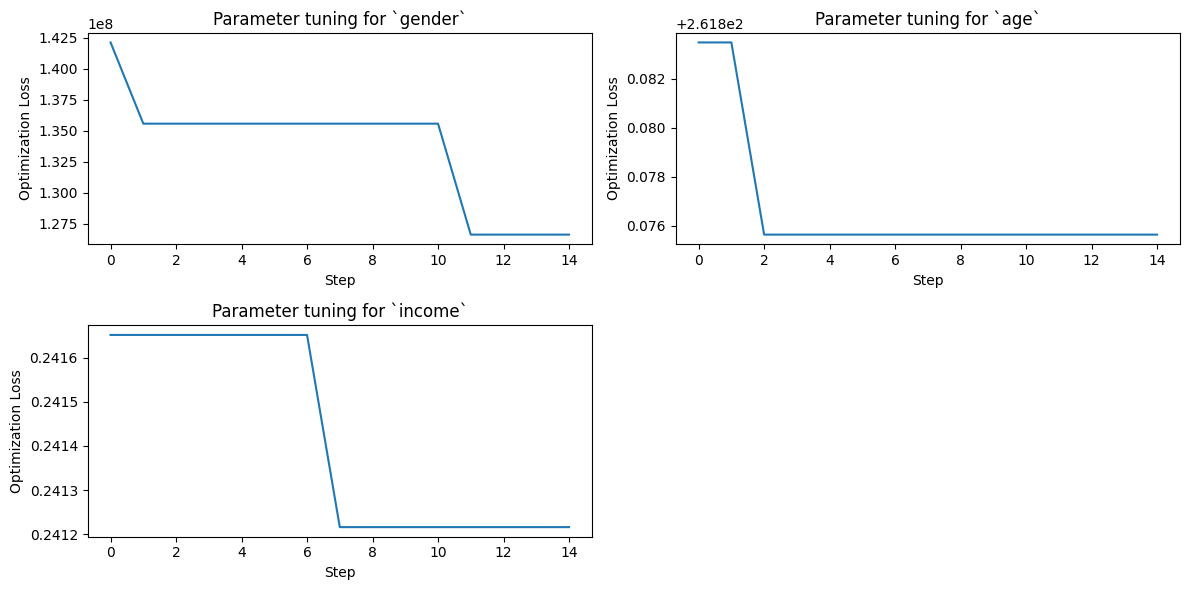

In [35]:
# Plot the optimization loss for each variable to assess tuning effectiveness
n_vars = len(variables_with_nan)
fig, axes = plt.subplots(nrows=(n_vars // 2 + n_vars % 2), ncols=2, figsize=(12, n_vars * 2))
axes = axes.flatten()

for i, var in enumerate(variables_with_nan):
    sns.lineplot(losses[var], ax=axes[i])
    axes[i].set_title(f'Parameter tuning for `{var}`')
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel('Optimization Loss')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
if n_vars % 2 != 0:
    axes[-1].axis('off')
    
plt.tight_layout()
plt.show()

**Finalizing the Imputation**

After tuning, we run additional iterations to finalize the imputation, ensuring convergence of the imputed values.

In [36]:
# Complete the imputation process with additional iterations using optimized parameters
kernel.mice(iterations=15, variable_parameters=optimal_parameters)

**Checking Imputation Convergence**

Checking the convergence of imputations for each variable confirms the stability of the imputation process.

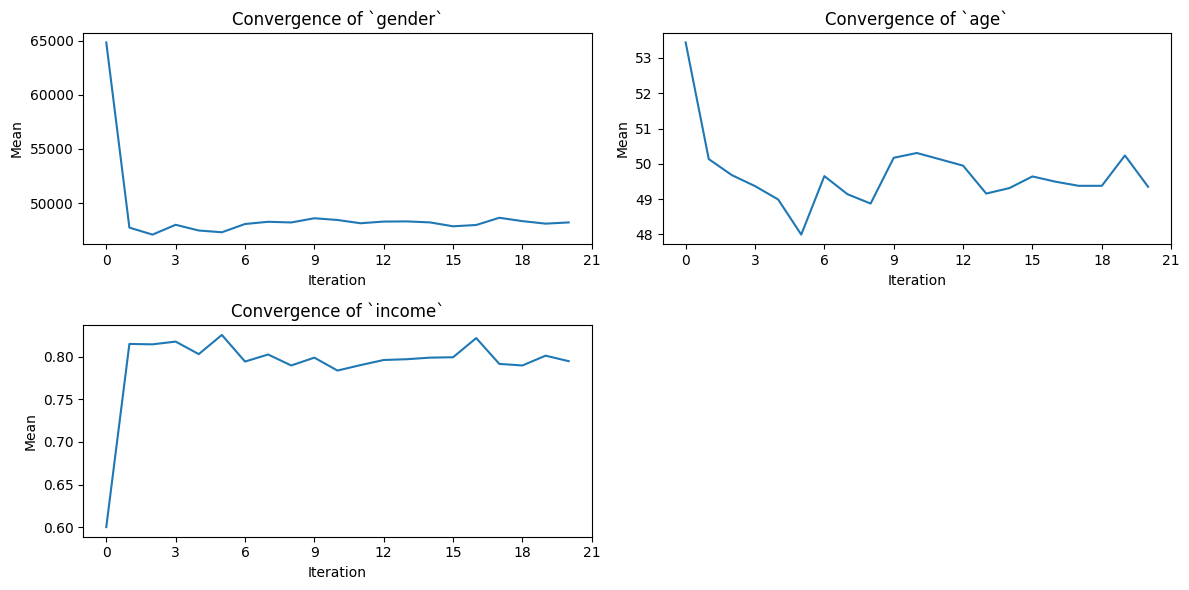

In [37]:
# Visualize the convergence of imputed means to ensure stability
kernel_means = kernel.get_means(datasets=[0])[0]
fig, axes = plt.subplots(nrows=(n_vars // 2 + n_vars % 2), ncols=2, figsize=(12, n_vars * 2))
axes = axes.flatten()

for i, (mean, var) in enumerate(zip(kernel_means.values(),variables_with_nan)):
    sns.lineplot(mean, ax=axes[i])
    axes[i].set_title(f'Convergence of `{var}`')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Mean')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
if n_vars % 2 != 0:
    axes[-1].axis('off')
    
plt.tight_layout()
plt.show()

**Retrieving the Imputed Data**

Once the imputation process is finalized, we retrieve the completed dataset and reverse any temporary encodings.

In [38]:
# Retrieve the completed dataset from the imputation kernel
imputed_df = kernel.complete_data(dataset=0)

# Reverse the 'gender' encoding
imputation_df[['gender']] = encoder.inverse_transform(imputation_df[['gender']])
imputed_df[['gender']] = encoder.inverse_transform(imputed_df[['gender']])

# Inspect the imputed dataset
display(imputed_df)
print(imputed_df.isna().sum())

,gender,age,income,member_days,n_completed_B1,n_completed_B2,n_completed_B3,n_completed_B4,n_completed_D1,n_completed_D2,n_completed_D3,n_completed_D4,n_received_B1,n_received_B2,n_received_B3,n_received_B4,n_received_D1,n_received_D2,n_received_D3,n_received_D4,n_received_I1,n_received_I2,n_viewed_B1,n_viewed_B2,n_viewed_B3,n_viewed_B4,n_viewed_D1,n_viewed_D2,n_viewed_D3,n_viewed_D4,n_viewed_I1,n_viewed_I2,avg_transaction,n_transactions,net_expense
person,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,F,66.0,39000.0,566,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,2.266667,9,20.40
0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,413,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.670000,3,77.01
38fe809add3b4fcf9315a9694bb96ff5,M,70.0,49000.0,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.383333,6,14.30
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,480,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,22.752857,7,159.27
a03223e636434f42ac4c3df47e8bac43,M,33.0,31000.0,393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.550000,3,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,54000.0,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.861429,7,20.03
2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,72000.0,50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.710000,7,25.97
01d26f638c274aa0b965d24cefe3183f,M,49.0,73000.0,583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.967500,8,39.74


gender             0
age                0
income             0
member_days        0
n_completed_B1     0
n_completed_B2     0
n_completed_B3     0
n_completed_B4     0
n_completed_D1     0
n_completed_D2     0
n_completed_D3     0
n_completed_D4     0
n_received_B1      0
n_received_B2      0
n_received_B3      0
n_received_B4      0
n_received_D1      0
n_received_D2      0
n_received_D3      0
n_received_D4      0
n_received_I1      0
n_received_I2      0
n_viewed_B1        0
n_viewed_B2        0
n_viewed_B3        0
n_viewed_B4        0
n_viewed_D1        0
n_viewed_D2        0
n_viewed_D3        0
n_viewed_D4        0
n_viewed_I1        0
n_viewed_I2        0
avg_transaction    0
n_transactions     0
net_expense        0
dtype: int64


**Visualizing the Data Distributions**

Visualizing the distributions of original and imputed data helps validate the imputation process by comparing the characteristics of the filled values against the original data. The statistical properties of the imputed variables seem to have remained consistent, thereby providing a reliable foundation for any subsequent analyses or predictive modeling.

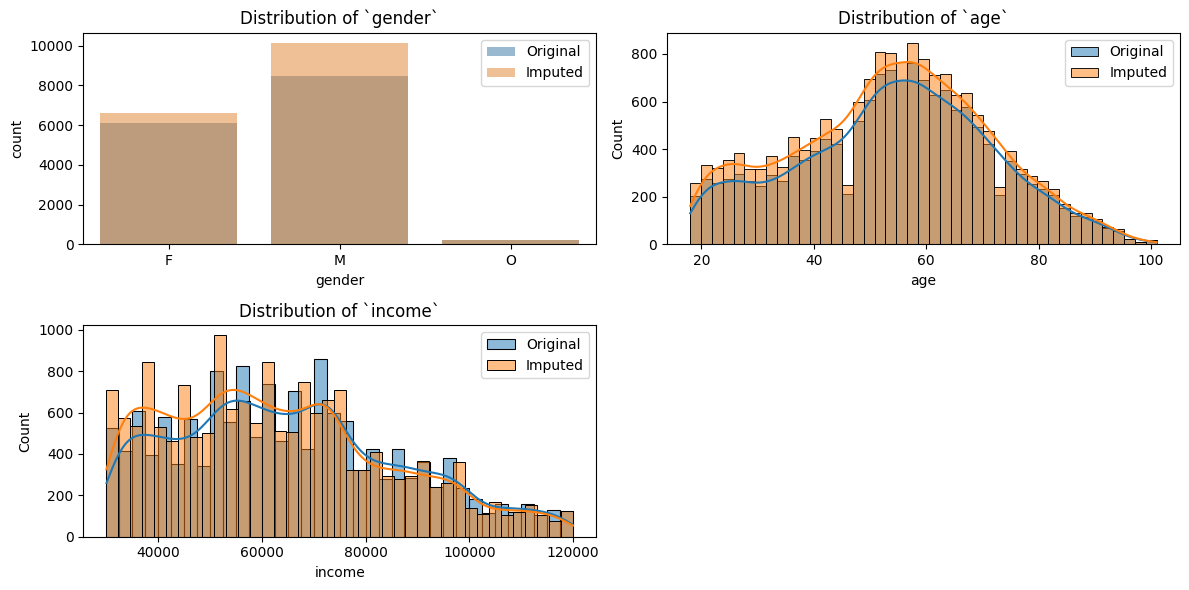

In [39]:
# Plot the distributions of original and imputed data to evaluate imputation quality
fig, axes = plt.subplots(nrows=(n_vars // 2 + n_vars % 2), ncols=2, figsize=(12, n_vars * 2))
axes = axes.flatten()

for i, var in enumerate(variables_with_nan):
    if var == 'gender':
        sns.countplot(imputation_df, x=var, ax=axes[i], label='Original', alpha=0.5)
        sns.countplot(imputed_df, x=var, ax=axes[i], label='Imputed', alpha=0.5)
    else:
        sns.histplot(imputation_df[var], kde=True, ax=axes[i], label='Original')
        sns.histplot(imputed_df[var], kde=True, ax=axes[i], label='Imputed')
    axes[i].set_title(f'Distribution of `{var}`')
    axes[i].legend()
if n_vars % 2 != 0:
    axes[-1].axis('off')
    
plt.tight_layout()
plt.show()

**Updating the Main Profile Data**

Finally, we merge the imputed data back into the main profile dataset, ensuring that the imputed values are incorporated into our analysis moving forward.

In [40]:
# Merge the imputed data back into the main profile dataset, updating missing values
imputed_df.reset_index(inplace=True)
profile = imputed_df.merge(profile[['id', 'date']], left_on='person', right_on='id').drop(['person', *offer_columns], axis=1)

display(profile)

,gender,age,income,member_days,avg_transaction,n_transactions,net_expense,id,date
0,F,66.0,39000.0,566,2.266667,9,20.40,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12
1,F,55.0,112000.0,413,25.670000,3,77.01,0610b486422d4921ae7d2bf64640c50b,2017-07-15
2,M,70.0,49000.0,51,2.383333,6,14.30,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12
3,F,75.0,100000.0,480,22.752857,7,159.27,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09
4,M,33.0,31000.0,393,1.550000,3,4.65,a03223e636434f42ac4c3df47e8bac43,2017-08-04
...,...,...,...,...,...,...,...,...,...
16995,F,45.0,54000.0,89,2.861429,7,20.03,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04
16996,M,61.0,72000.0,50,3.710000,7,25.97,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13
16997,M,49.0,73000.0,583,4.967500,8,39.74,01d26f638c274aa0b965d24cefe3183f,2017-01-26
16998,F,83.0,50000.0,908,13.547857,14,189.67,9dc1421481194dcd9400aec7c9ae6366,2016-03-07


### Binning & One-Hot Encoding

In the final step of our Data Processing, we apply binning to some features of the `profile` dataset and one-hot encoding to some categorical features of the `portfolio` dataset. These transformations are critical for preparing the data for further analysis and modeling.

**Binning Profile Data**

Binning age and income data allows us to categorize these continuous variables into discrete groups, which can help reveal patterns across different demographic segments.

In [41]:
# Bin 'age' into categorical groups for easier analysis and visualization
profile['age_group'] = pd.cut(profile['age'], bins=[12, 20, 30, 64, 110], labels=['teen', 'young adult', 'adult', 'elderly'])

# Bin 'income' into groups using an even range of income values
profile['income_group'] = pd.cut(profile['income'], range(int(profile['income'].min()-20000), int(profile['income'].max())+20000, 20000))

# Display the updated profile data to confirm the new columns
display(profile)

,gender,age,income,member_days,avg_transaction,n_transactions,net_expense,id,date,age_group,income_group
0,F,66.0,39000.0,566,2.266667,9,20.40,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,elderly,"(30000, 50000]"
1,F,55.0,112000.0,413,25.670000,3,77.01,0610b486422d4921ae7d2bf64640c50b,2017-07-15,adult,"(110000, 130000]"
2,M,70.0,49000.0,51,2.383333,6,14.30,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,elderly,"(30000, 50000]"
3,F,75.0,100000.0,480,22.752857,7,159.27,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,elderly,"(90000, 110000]"
4,M,33.0,31000.0,393,1.550000,3,4.65,a03223e636434f42ac4c3df47e8bac43,2017-08-04,adult,"(30000, 50000]"
...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,54000.0,89,2.861429,7,20.03,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,adult,"(50000, 70000]"
16996,M,61.0,72000.0,50,3.710000,7,25.97,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,adult,"(70000, 90000]"
16997,M,49.0,73000.0,583,4.967500,8,39.74,01d26f638c274aa0b965d24cefe3183f,2017-01-26,adult,"(70000, 90000]"
16998,F,83.0,50000.0,908,13.547857,14,189.67,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,elderly,"(30000, 50000]"


**Encoding Portfolio Data**

For the `portfolio` dataset, we focus on transforming the `channels` column, which contains lists of media through which offers were distributed. We convert these lists into a format suitable for one-hot encoding, thereby creating individual binary columns for each channel.

In [42]:
# Convert the string representation of channel lists in 'portfolio' into actual lists
portfolio['channels'] = portfolio['channels'].apply(ast.literal_eval)

# Transform the list of channels into a string and apply one-hot encoding
channels_dummies = portfolio['channels'].apply(lambda x: '|'.join(x)).str.get_dummies(sep='|')

# Prefix the new dummy variable columns for clarity
channels_dummies.columns = [f'channel_{col}' for col in channels_dummies.columns]

# Concatenate the original portfolio DataFrame with the new dummy variables
portfolio = pd.concat([portfolio, channels_dummies], axis=1)

# Display the updated portfolio DataFrame to check the new dummy columns
display(portfolio)

,reward,channels,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,B1,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,B2,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,I1,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,B3,1,1,0,1
4,5,"[web, email]",20,10,discount,D1,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,D2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,D3,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,I2,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,B4,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,D4,1,1,0,1


## Exploratory Analysis

For the Exploratory Analysis, we consider only the entries that do not contain imputed data. This approach ensures the authenticity and reliability of the insights derived from the actual data provided by customers.

In [43]:
profile_eda = profile.query('id not in @incomplete_entries')
transcript_eda = transcript.query('person not in @incomplete_entries')

### Demographics

In this section, we focus on the demographic attributes captured in the `profile` dataset, aiming to uncover patterns in Starbuck's customer population.

**Distribution of Age by Gender**

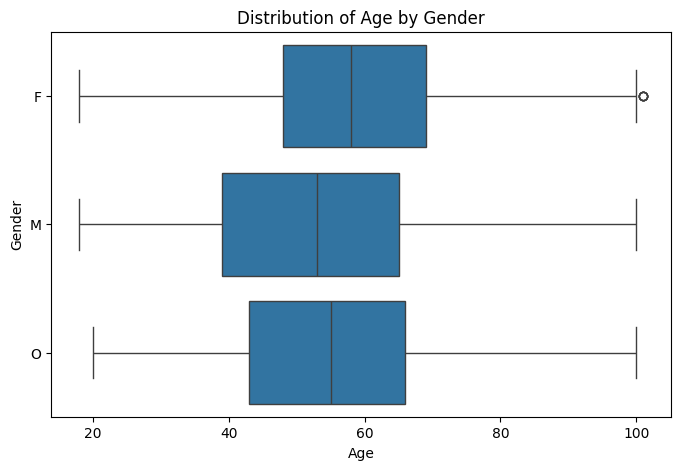

In [44]:
plt.figure(figsize=(8, 5))
plt.title('Distribution of Age by Gender')
sns.boxplot(x="age", y= "gender", data=profile_eda)
plt.xlabel('Age')
plt.ylabel('Gender')
plt.show()

- The boxplots show that age distributions are quite similar across genders, with the median value for female customers being slightly higher.

**Distribution of Income by Gender**

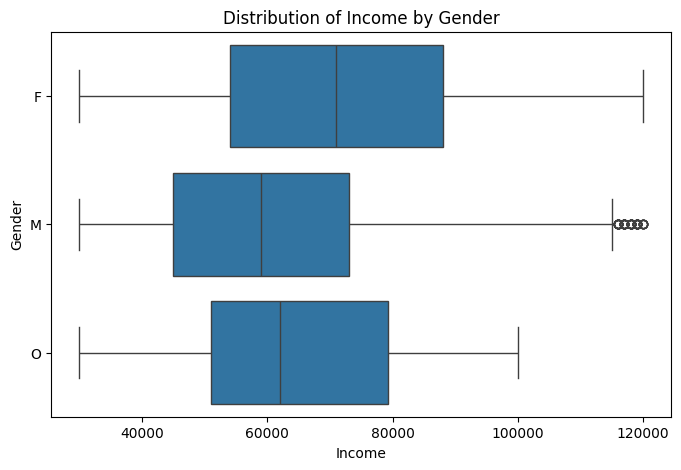

In [45]:
plt.figure(figsize=(8, 5))
plt.title('Distribution of Income by Gender')
sns.boxplot(x="income", y= "gender", data=profile_eda)
plt.xlabel('Income')
plt.ylabel('Gender')
plt.show()

- The income distributions indicate that females tend to have a slightly wider income range with a higher median value compared to other genders.

**Distribution of Income by Age Group**

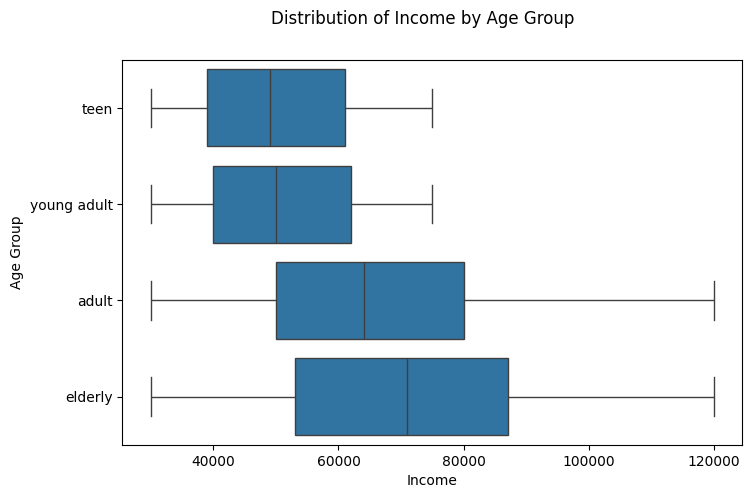

In [46]:
plt.figure(figsize=(8, 5))
plt.suptitle('Distribution of Income by Age Group')
sns.boxplot(x="income", y= "age_group", data=profile_eda)
plt.xlabel('Income')
plt.ylabel('Age Group')
plt.show()

- Teens and young adults typically show lower income levels.
- Also, adult and elderly customers show a wider income range.

**Customer Subscriptions Over Months and Years**

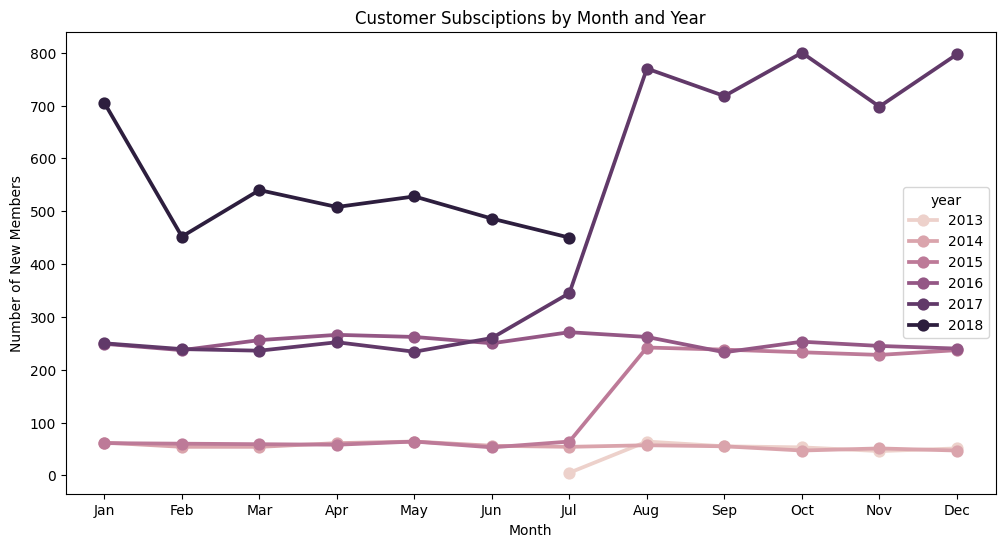

In [47]:
profile_eda = profile_eda.copy()  # to avoid SettingWithCopyWarning
profile_eda['month'] = profile_eda['date'].dt.month
profile_eda['year'] = profile_eda['date'].dt.year
membership_subs = profile_eda.groupby(['year','month'], as_index=False).agg({'id':'count'})

plt.figure(figsize=(12, 6))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs)
plt.ylabel('Number of New Members')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.title('Customer Subsciptions by Month and Year')
plt.show()

- There was a slight increase in subscriptions in July 2013, followed by stable numbers until July 2015, when there was a considerable increase. Subscriptions then remained steady until July 2017, which saw an even more significant increase, stabilizing for the remainder of the year. In January 2018, the numbers dropped and have remained stable since.
- Peaking in July every other year is a notable pattern.

**Customer Subscriptions by Year and Demographic Attributes**

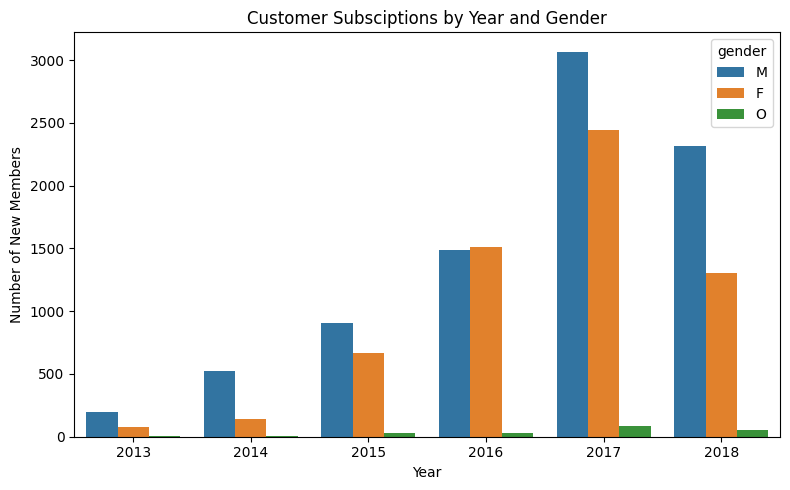

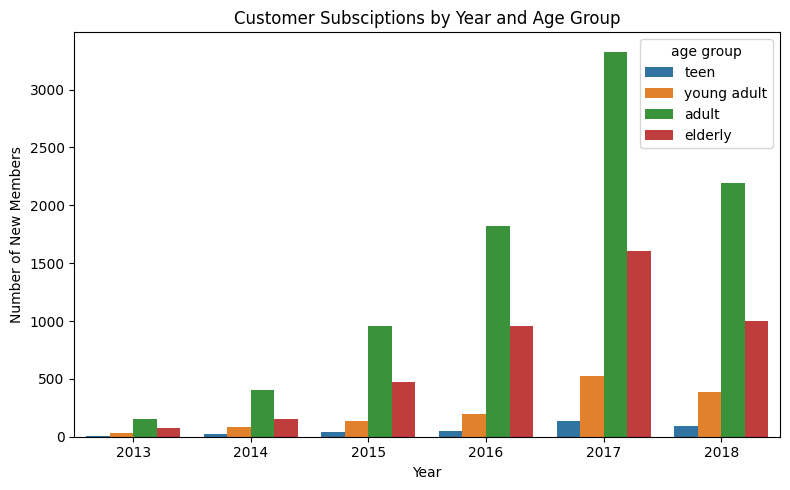

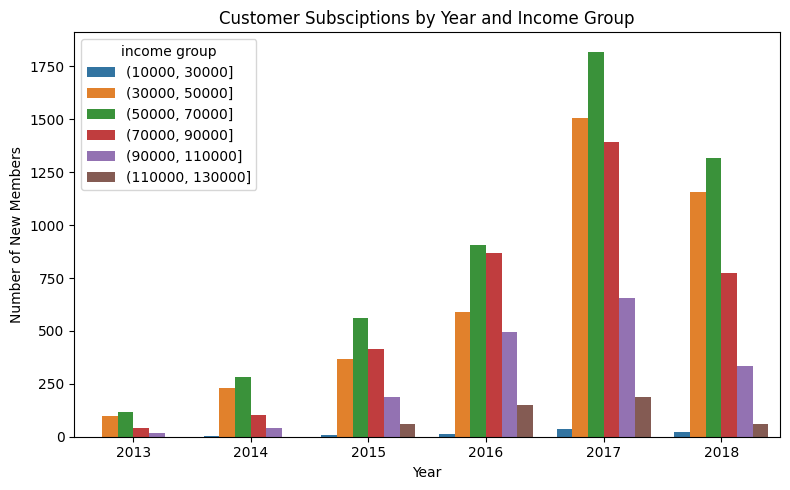

In [48]:
# Gender-based subscriptions over years
plt.figure(figsize=(8, 5))
sns.countplot(x='year', data=profile_eda, hue='gender')
plt.title('Customer Subsciptions by Year and Gender')
plt.xlabel('Year')
plt.ylabel('Number of New Members')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Age group-based subscriptions over years
plt.figure(figsize=(8, 5))
sns.countplot(x='year', data=profile_eda, hue='age_group')
plt.title('Customer Subsciptions by Year and Age Group')
plt.xlabel('Year')
plt.ylabel('Number of New Members')
plt.xticks(rotation=0)
plt.legend(title='age group')
plt.tight_layout()
plt.show()

# Income group-based subscriptions over years
plt.figure(figsize=(8, 5))
sns.countplot(x='year', data=profile_eda, hue='income_group')
plt.title('Customer Subsciptions by Year and Income Group')
plt.xlabel('Year')
plt.ylabel('Number of New Members')
plt.xticks(rotation=0)
plt.legend(title='income group')
plt.tight_layout()
plt.show()

Gender Analysis:
- The number of customers joining annually has generally risen over the years. The apparent decrease in 2018 is misleading, as the data was collected partway through that year.
- The number of new male customers considerably surpasses that of female customers, particularly in 2013, 2014, and 2018. However, in 2016, the numbers of male and female customers who joined were equal.
- While the number of new customers of 'Other' gender has increased in recent years, their numbers remain markedly lower than those of male and female customers.

Age Group Analysis:
- The majority of new customers are adults, with elderly customers joining at half the number of adults. The number of new teenage and young adult customers is significantly lower.
- Notably, since 2015, the discrepancy in numbers between older and younger customers has widened, increasingly favouring the older demographic.

Income Group Analysis:
- Across all years, the majority of new customers fall into the 50-70k income group.
- The 30-50k group is the second largest, closely following the 50-70k group, except in 2015 and 2016, when it was only two-thirds of its size.
- The 70-90k group was considerably smaller during 2013 and 2014 but has grown substantially ever since, surpassing the 30-50k group and nearly reaching the size of the 50-70k group during 2015 and 2016.
- The proportion of new customers in the 90-110k group increased in 2015 and has remained relatively stable since then.
- The proportion of new customers in the >110k group increased in 2016 and 2017 but has consistently been significantly lower than that of the other groups.

### Transcripts

In this section, we explore the transactional data captured in the `transcript` dataset. We explore the temporal dynamics of customer interactions with offers and transactions, and examine the effectiveness of different communication channels and offer types

**Temporal Patterns of Events**

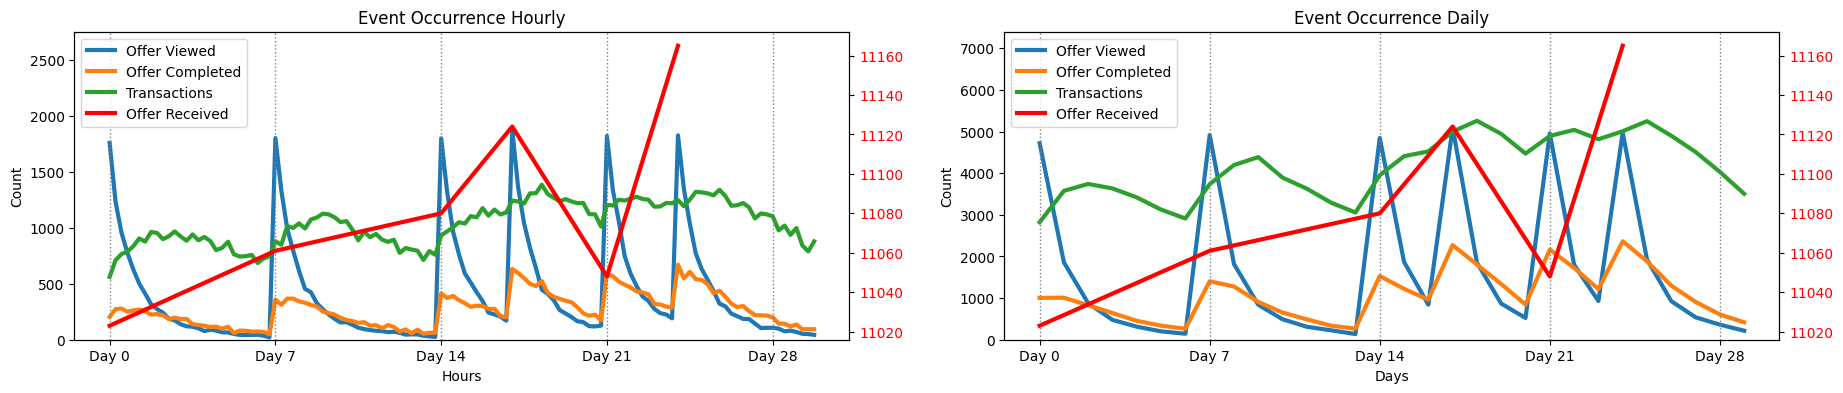

In [49]:
# Calculate events per hour
received_hourly = transcript_eda[transcript_eda['event'] == 'offer received'].value_counts('time').sort_index()
viewed_hourly = transcript_eda[transcript_eda['event'] == 'offer viewed'].value_counts('time').sort_index()
completed_hourly = transcript_eda[transcript_eda['event'] == 'offer completed'].value_counts('time').sort_index()
transaction_hourly = transcript_eda[transcript_eda['event'] == 'transaction'].value_counts('time').sort_index()

# Calculate events per day
transcript_eda = transcript_eda.assign(days_since_start = transcript_eda['time']/24).astype({'days_since_start': 'int64'})
received_daily = transcript_eda[transcript_eda['event'] == 'offer received'].value_counts('days_since_start').sort_index()
viewed_daily = transcript_eda[transcript_eda['event'] == 'offer viewed'].value_counts('days_since_start').sort_index()
completed_daily = transcript_eda[transcript_eda['event'] == 'offer completed'].value_counts('days_since_start').sort_index()
transaction_daily = transcript_eda[transcript_eda['event'] == 'transaction'].value_counts('days_since_start').sort_index()

# Visualization setup
fig, axs = plt.subplots(1,2, figsize = (22, 4))

# Plot hourly data
hours = viewed_hourly.index.values
ax1 = axs[0]
line1, = ax1.plot(hours, viewed_hourly, lw=3, label='Offer Viewed')
line2, = ax1.plot(hours, completed_hourly, lw=3, label='Offer Completed')
line3, = ax1.plot(hours, transaction_hourly, lw=3, label='Transactions')
ax1.legend(loc='upper left')
ax1.set_ylim([0, 2750])
ax1.set_xlabel('Hours')
ax1.set_ylabel('Count')
ax1.set_title('Event Occurrence Hourly')

# Plot daily data
days = np.arange(30)
ax2 = axs[1]
line4, = ax2.plot(days, viewed_daily, lw=3, label='Offer Viewed')
line5, = ax2.plot(days, completed_daily, lw=3, label='Offer Completed')
line6, = ax2.plot(days, transaction_daily, lw=3, label='Transactions')
ax2.set_ylim([0, 7400])
ax2.set_xlabel('Days')
ax2.set_ylabel('Count')
ax2.set_title('Event Occurrence Daily')

# Add vertical dotted lines on the start of weeks
hours_per_day = 24
hours_per_week = 7 * hours_per_day
weeks_in_days = list(range(0, 30, 7))
for ax in [ax1, ax2]:
    if ax == ax1:
        week_starts_hours = [w * hours_per_week for w in range(0, 5)]
        for hour in week_starts_hours:
            ax.axvline(hour, color='gray', linestyle=':', lw=1)
        ax.set_xticks(week_starts_hours)
        ax.set_xticklabels([f'Day {day}' for day in weeks_in_days])
    else:
        for day in weeks_in_days:
            ax.axvline(day, color='gray', linestyle=':', lw=1)
        ax.set_xticks(weeks_in_days)
        ax.set_xticklabels([f'Day {day}' for day in weeks_in_days])
        
# Create secondary y-axis for the hourly plot
ax3 = ax1.twinx()
line7, = ax3.plot(received_hourly.index.values, received_hourly, 'r-', lw=3, label='Offer Received')
ax3.tick_params(axis='y', labelcolor='r')

# Create secondary y-axis for the daily plot
ax4 = ax2.twinx()
line7, = ax4.plot(received_daily.index.values, received_daily, 'r-', lw=3, label='Offer Received')
ax4.tick_params(axis='y', labelcolor='r')

# Combine the handles and labels from both axes to create a joint legend
lines = [line4, line5, line6, line7]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
ax2.legend(lines, labels, loc='upper left')

plt.show()

- Offers were distributed at the start of each of the first two weeks, and then at the start and the middle of each of the next two weeks of the promotional period. 
- Each spike in 'Offer Received' is accompanied by a spike in 'Offer Viewed', indicating that most customers who view the received offers do so immediately. 
- 'Transactions' spike slightly after the peaks in 'Offer Viewed' and 'Offer Completed', which suggests a deliberation period where customers evaluate the offers before acting on them.

**Distribution of Aggregated Transaction Metrics**

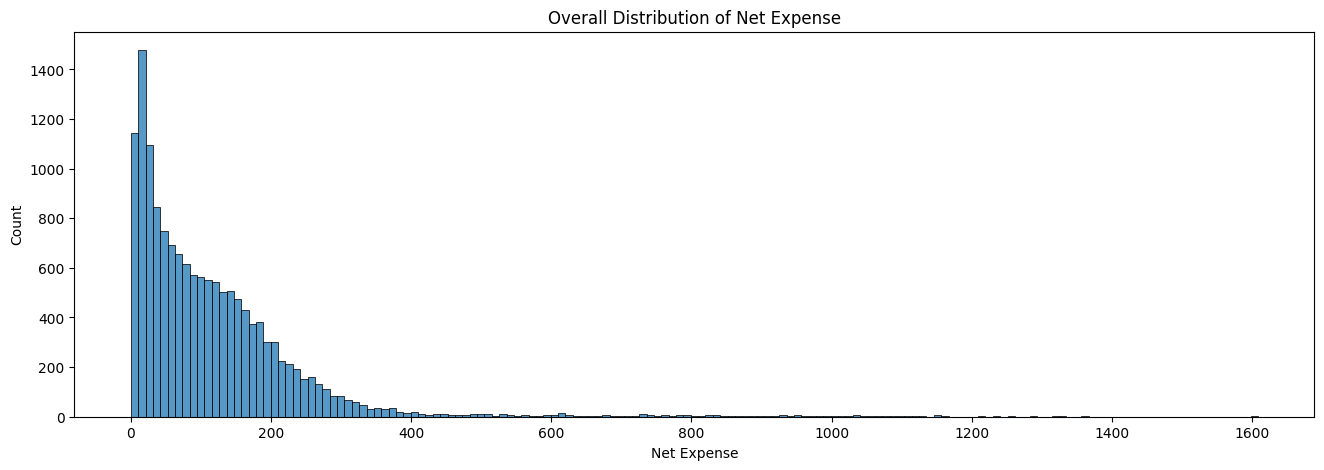

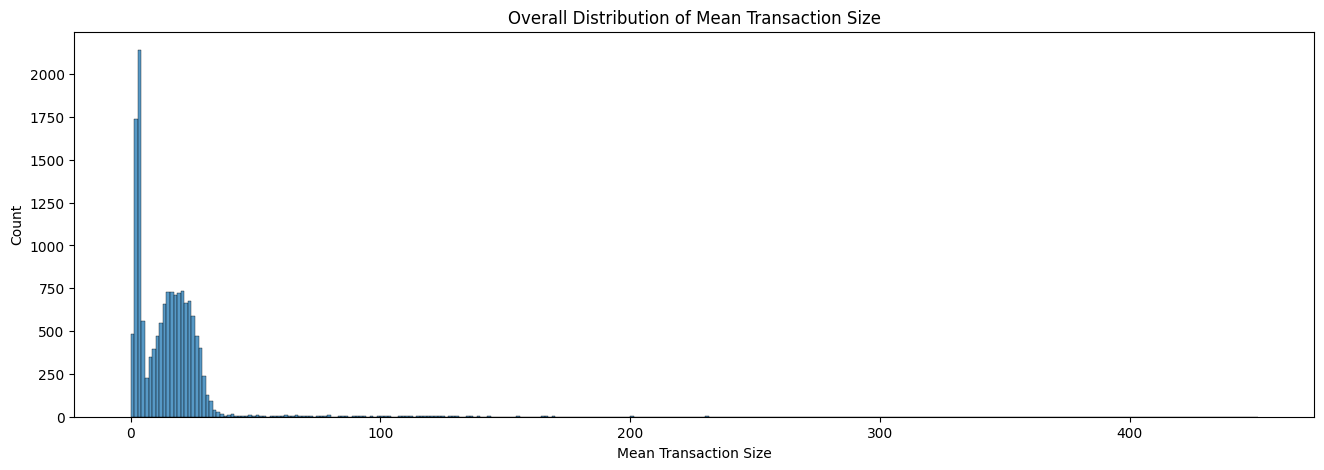

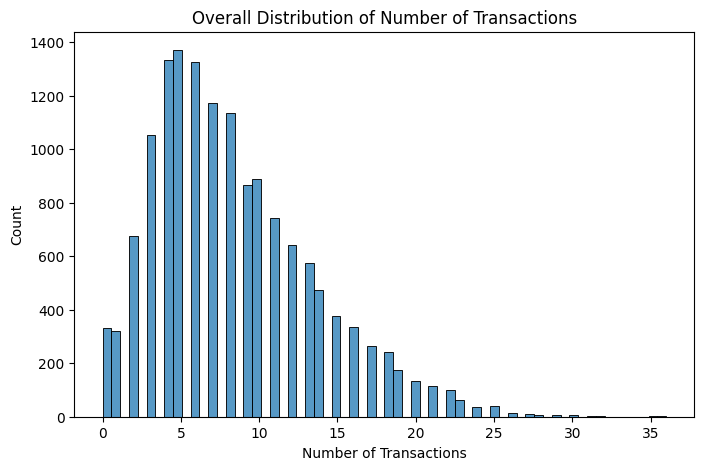

In [50]:
# Visualizing the distribution of net expense
plt.figure(figsize=(16, 5))
plt.title('Overall Distribution of Net Expense')
sns.histplot(profile_eda["net_expense"], kde=False)
plt.xlabel('Net Expense')
plt.show()

# Visualizing the distribution of mean transaction size
plt.figure(figsize=(16, 5))
plt.title('Overall Distribution of Mean Transaction Size')
sns.histplot(profile_eda["avg_transaction"], kde=False)
plt.xlabel('Mean Transaction Size')
plt.show()

# Visualizing the distribution of the number of transactions
plt.figure(figsize=(8, 5))
plt.title('Overall Distribution of Number of Transactions')
sns.histplot(profile_eda["n_transactions"], kde=False)
plt.xlabel('Number of Transactions')
plt.show()

- The majority of customers incurred relatively low net expenses, predominantly concentrating around $50 or less.
- While most transactions averaged around $10, there was also a noteworthy cluster of customers whose average transaction size approached $25.
- The majority of customers engaged in 4 to 10 transactions throughout the promotional period.

**Effectiveness of Communication Channels**

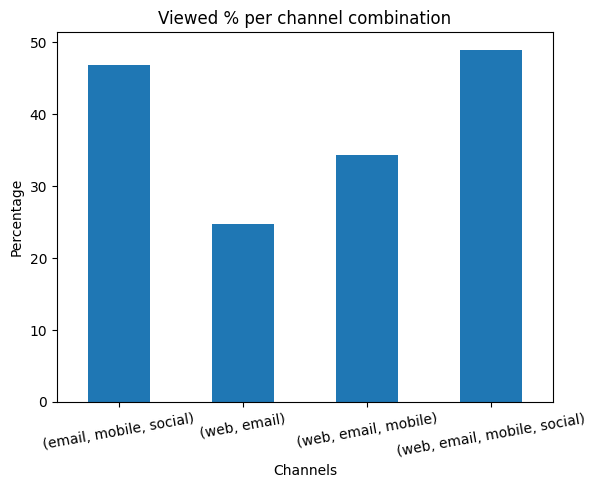

In [51]:
helper_df = transcript_eda.merge(portfolio[['offer_id', 'channels']], on='offer_id', how='left').query('event in ["offer received", "offer viewed"]')
helper_df['channels'] = helper_df['channels'].apply(tuple)

# Calculate percentage of "offer viewed" for each combination of channels
viewed_percentage = helper_df.groupby('channels')['event'].apply(lambda x: (x == 'offer viewed').mean() * 100)

viewed_percentage.plot(kind='bar')
plt.title('Viewed % per channel combination')
plt.xlabel('Channels')
plt.ylabel('Percentage')
plt.xticks(rotation=10)
plt.show()

- Comparing the '(web, email)' and '(web, email, mobile)' bars indicates that distributing by 'mobile' is associated with a significant increase in view rates. 
- Comparing the '(web, email, mobile)' and '(web, email, mobile, social)' bars indicates that distributing by 'social' is associated with an even greater increase in view rates.
- Comparing the '(web, email, mobile, social)' and '(email, mobile, social)' bars indicates that distributing by 'web' does not significantly affect view rates.
- No insight can be drawn about the effect of distributing by 'email' since it is present in the distribution strategy of all offers.

**Offer Completion Analysis**

,offer_id,offer_type,reward,difficulty,duration
0,B1,bogo,10,10,7
1,B2,bogo,10,10,5
2,I1,informational,0,0,4
3,B3,bogo,5,5,7
4,D1,discount,5,20,10
5,D2,discount,3,7,7
6,D3,discount,2,10,10
7,I2,informational,0,0,3
8,B4,bogo,5,5,5
9,D4,discount,2,10,7


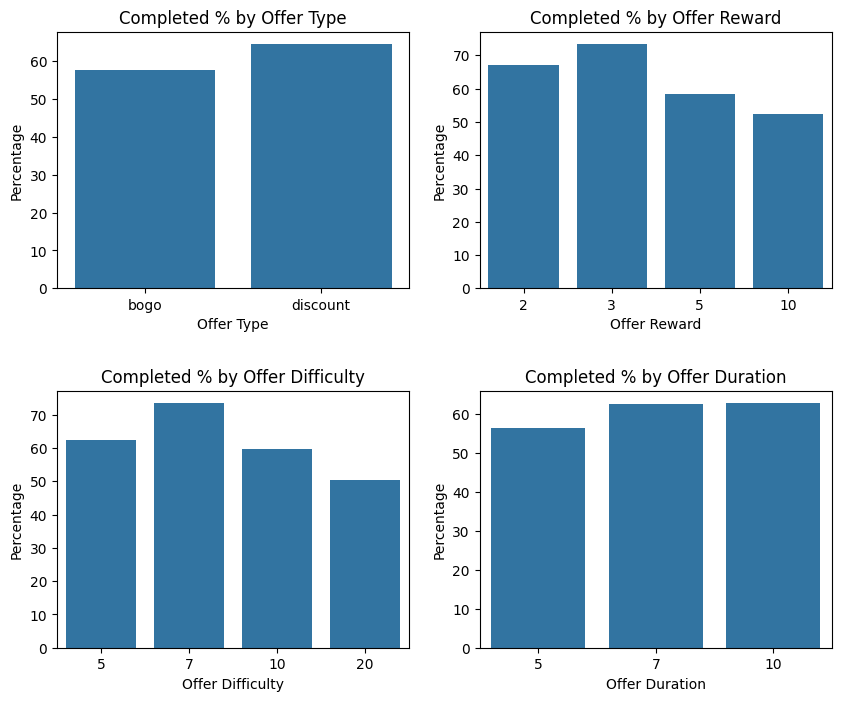

In [52]:
# Analyzing completion rates by different offer attributes
event_extended_df = transcript_eda.copy()
event_extended_df.event = event_extended_df.event.str.replace(" ", "_")
event_extended_df = pd.get_dummies(event_extended_df, prefix= "event", columns=["event"])
event_extended_df = event_extended_df.merge(portfolio, on='offer_id').merge(profile_eda, left_on='person', right_on='id')
event_extended_df = event_extended_df.query('offer_type_x != "informational"')

def get_feature_name(feature):
    feature_name = feature.split('_')
    feature_name = [word.capitalize() for word in feature_name]
    feature_name = ' '.join(feature_name)
    if feature_name == 'Year':
        feature_name = 'Join Year'
    return feature_name

display(portfolio[['offer_id',	'offer_type', 'reward',	'difficulty', 'duration']])

offer_features = ['offer_type_x', 'reward', 'difficulty_x', 'duration_x']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()
for i, feature in enumerate(offer_features):
    
    # Calculating completion percentage for each offer attribute
    offer = event_extended_df.groupby([feature]).agg({"event_offer_received":"sum", "event_offer_completed":"sum"})
    offer["receive_complete_percentage"] = offer.event_offer_completed / offer.event_offer_received * 100
    
    if feature.endswith('_x'):
        feature = feature[:-2]
    feature_name = get_feature_name(feature)
    if 'Offer' not in feature_name:
        feature_name = 'Offer ' + feature_name
    if 'offer' not in feature:
        offer.index = offer.index.astype(int)
    
    # Visualizing completion rates by each offer attribute
    sns.barplot(x=offer.index, y='receive_complete_percentage', data=offer, ax=axes[i])
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Percentage')
    axes[i].set_title(f'Completed % by {feature_name}')
fig.subplots_adjust(hspace=0.4)
plt.show()

- Bogo offers demonstrate slightly higher completion rates compared to discount offers.
- Offers with moderate difficulty and reward, and greater duration, seem to be associated with higher completion rates.

### Combination

In this section, we combine demographic `profile` attributes with the `transcript` data to uncover nuanced insights into the financial behavior and offer engagement of different customer groups.

**Distribution of Transaction metrics by Age, Income and Gender**

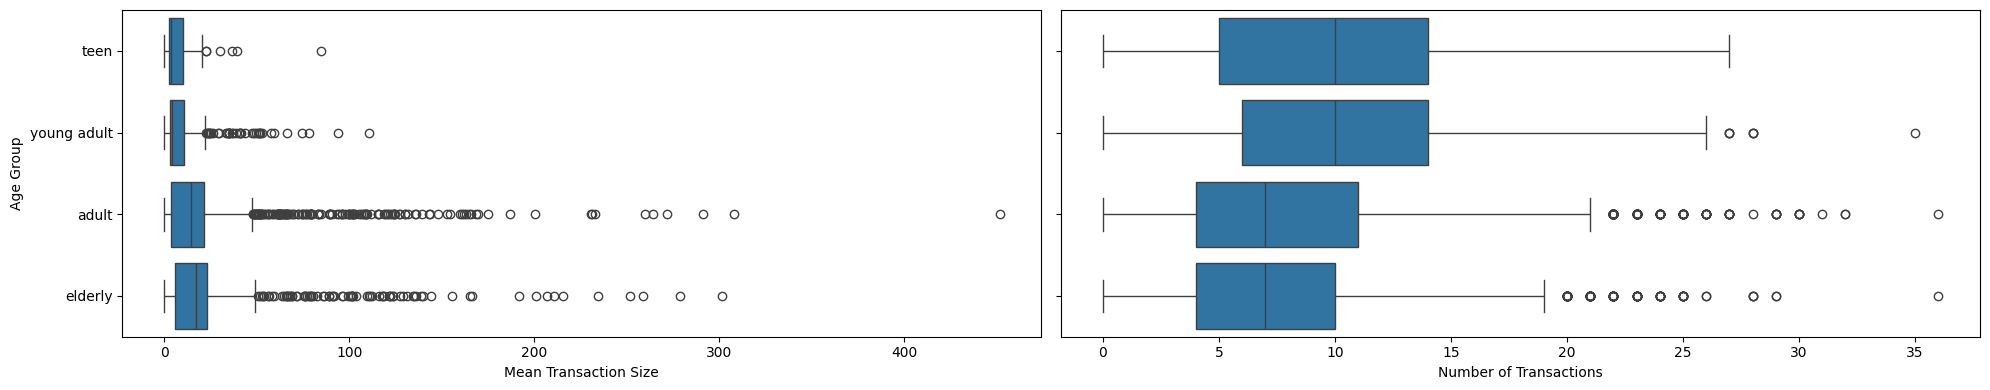

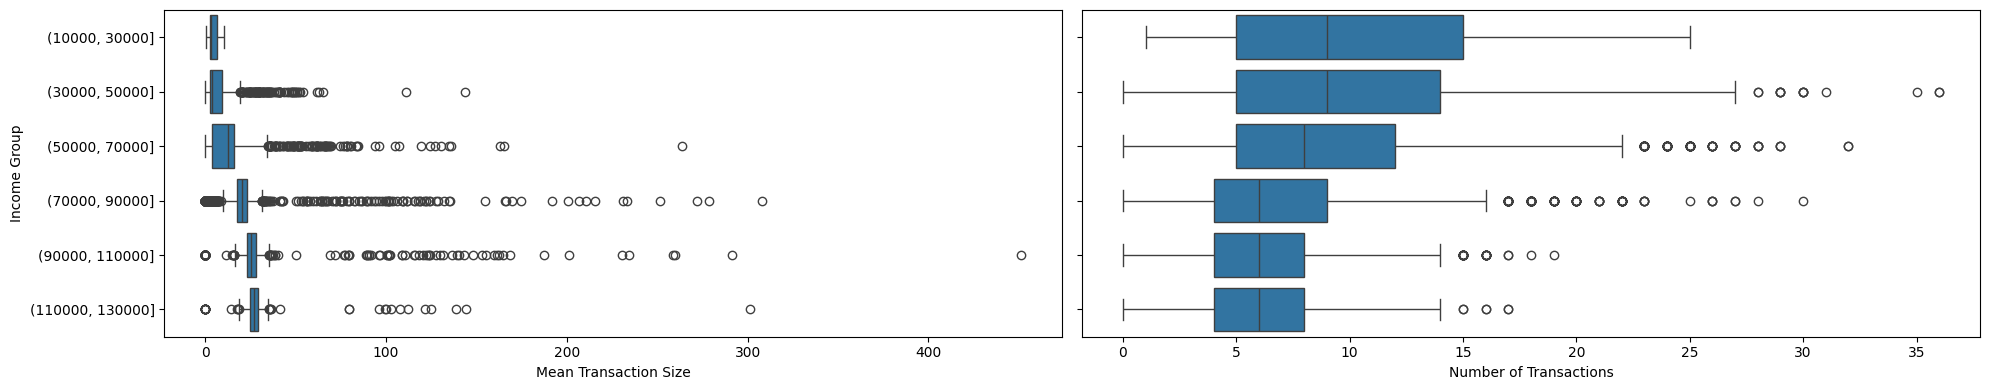

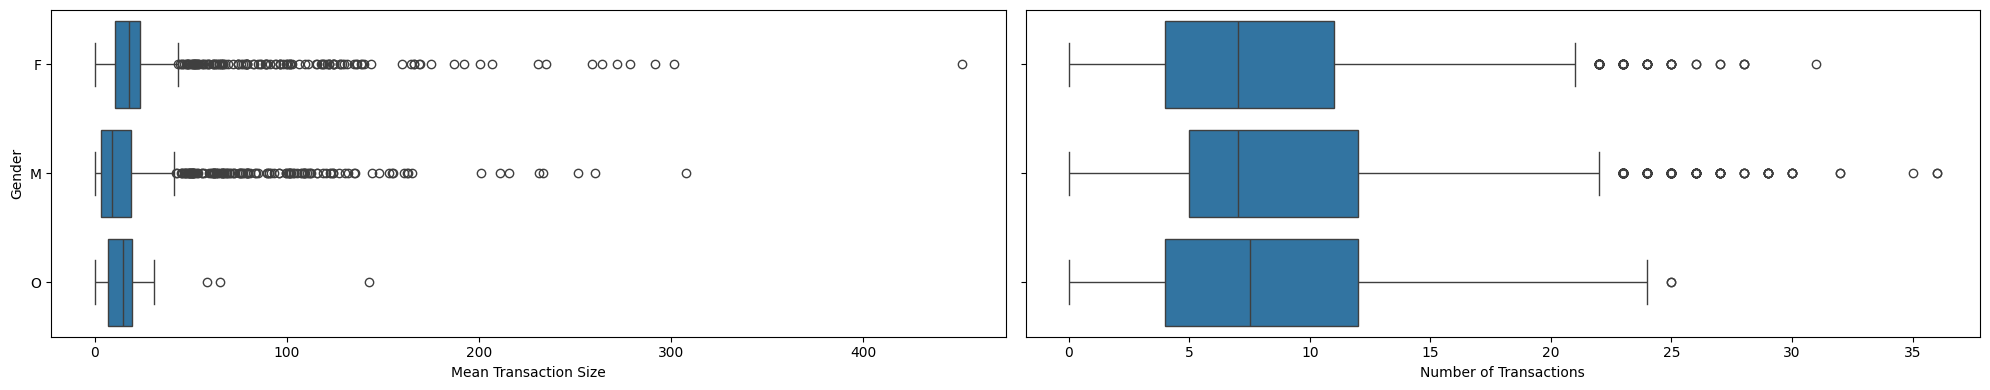

In [53]:
# Loop through demographic features to analyze transaction behaviors
for feature in ['age_group', 'income_group', 'gender']:
    feature_name = get_feature_name(feature)

    # Create side-by-side boxplots for comparing mean transaction sizes and number of transactions
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(20, 4), sharey=True)
    
    sns.boxplot(x="avg_transaction", y= feature, data=profile_eda, ax=ax0)
    ax0.set_xlabel('Mean Transaction Size')
    ax0.set_ylabel(feature_name)

    sns.boxplot(x="n_transactions", y= feature, data=profile_eda, ax=ax1)
    ax1.set_xlabel('Number of Transactions')
    ax1.set_ylabel(feature_name)
    
    fig.tight_layout()
    plt.show()

Age Group Analysis:
- Young adults and teens tend to have lower average transaction sizes.
- Adult and elderly customers exhibit a slightly lower number of transactions compared to other age groups.

Income Group Analysis:
- Higher income groups tend to have higher average transaction sizes.
- Also, higher income groups tend to engage into fewer transactions.

Gender Analysis:
- Males tend to exhibit slightly lower transaction sizes on average than other genders.
- The exhibited number of transactions does not seem to differ much across genders.

**View Percentages by Demographic Groups and Distribution Strategies**

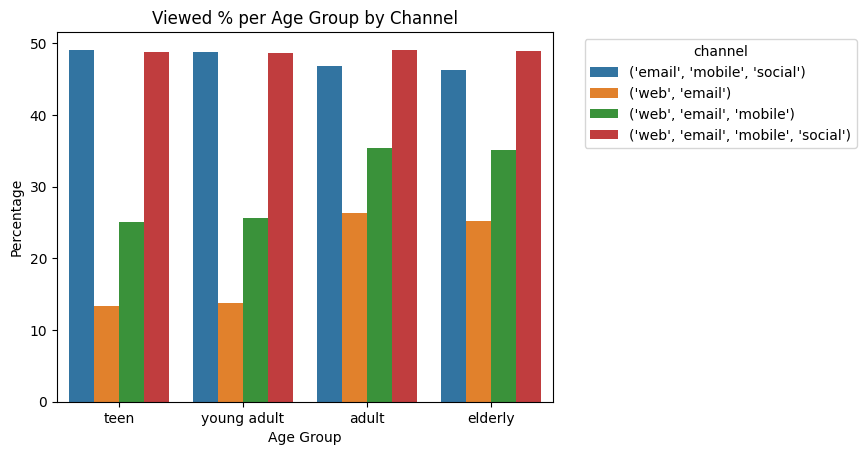

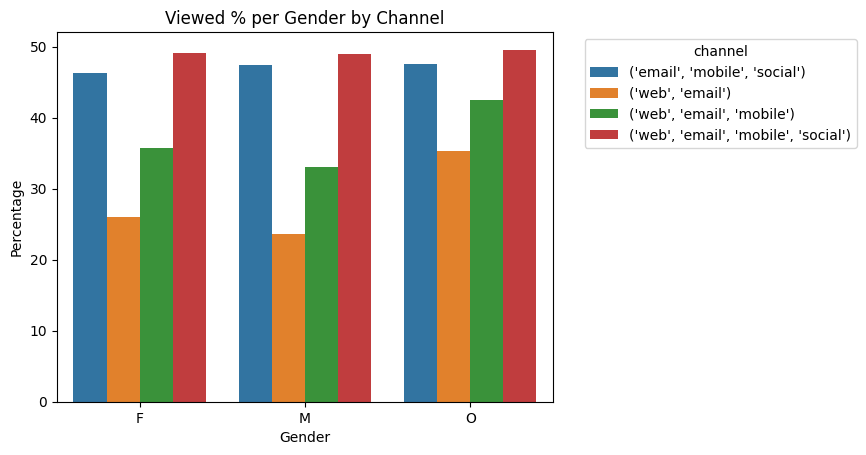

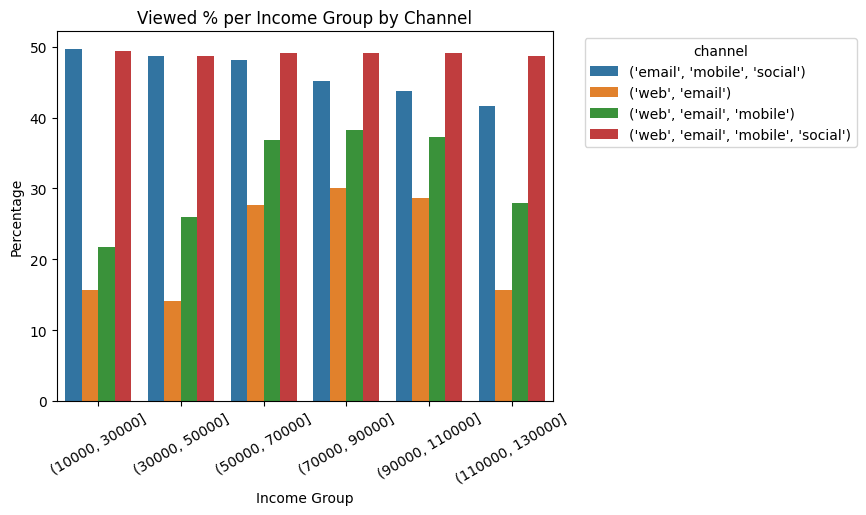

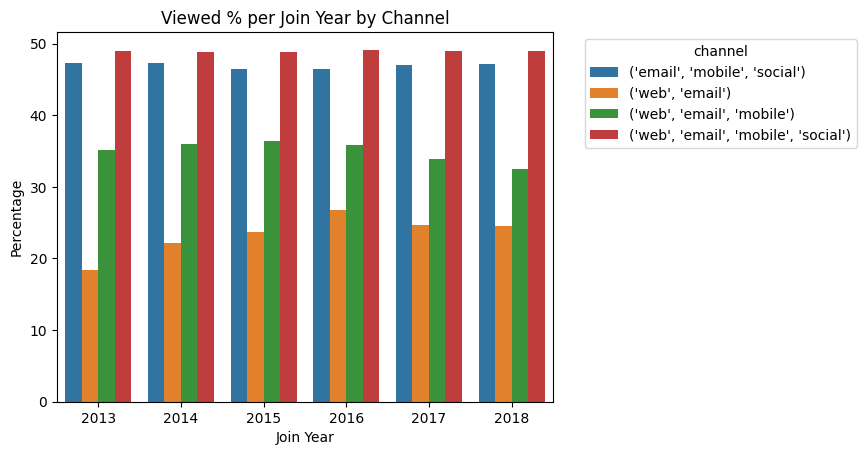

In [54]:
# Merge transaction and portfolio data, then filter for offer received and viewed events
helper_df = transcript_eda.merge(portfolio[['offer_id', 'channels']], on='offer_id', how='left').merge(profile_eda, left_on='person', right_on='id')
helper_df = helper_df.query('event in ["offer received", "offer viewed"]')
helper_df['channels'] = helper_df['channels'].apply(tuple)

# Analyze viewed percentages across different demographics and channel combinations
for feature in ['age_group', 'gender', 'income_group', 'year']:
    feature_name = get_feature_name(feature)
    viewed_percentage = helper_df.groupby([feature, 'channels'])['event'].apply(lambda x: (x == 'offer viewed').mean() * 100).reset_index()

    sns.barplot(data=viewed_percentage, x=feature, y='event', hue='channels')
    plt.title(f'Viewed % per {feature_name} by Channel')
    plt.ylabel('Percentage')
    plt.xlabel(feature_name)
    plt.legend(title='channel', bbox_to_anchor=(1.05, 1.0), loc='upper left')
    if feature_name == 'Income Group':
        plt.xticks(rotation=30)
    plt.show()

Across all age, gender, income and join year groups:
- Distribution through the "social" channel is associated with a significant increase in view rates.
- Distribution through the "mobile" channel is also associated with increased view rates.

Age Group Analysis:
- Offers that were not distributed through the "social" channel were viewed significantly less by the teen and young adult customers compared to adult and elderly customers.

Gender Analysis:
- Offers that were not distributed through the "social" channel were viewed significantly less by the female and male customers compared to those of 'Other' gender.

Income Group Analysis:
- Offers that were not distributed through the "social" channel were viewed significantly less in the <50k and >110k income groups compared to other groups.

Join Year Analysis:
- Offers distributed only through "web" and "email" were viewed slightly less by customers that joined in the earliest years.

**Completion Percentages by Demographic Groups and Offer Types**

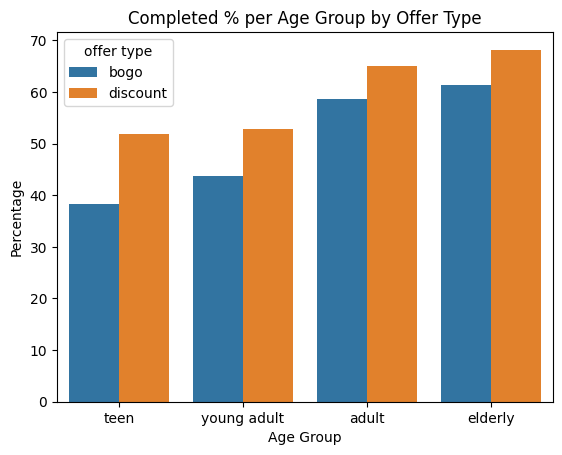

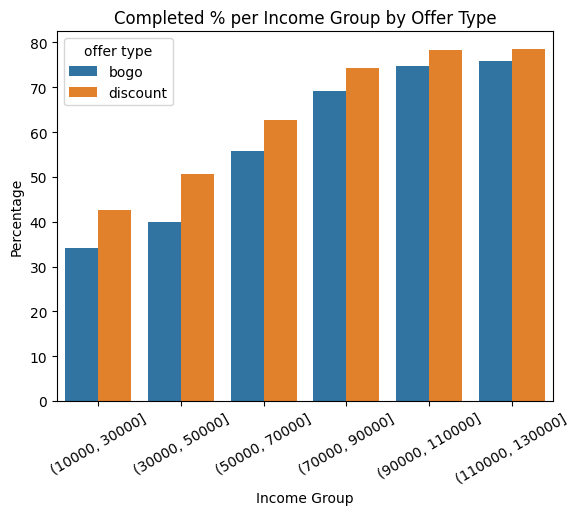

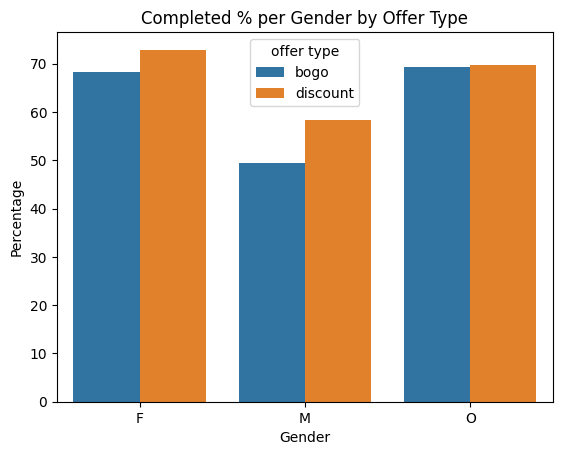

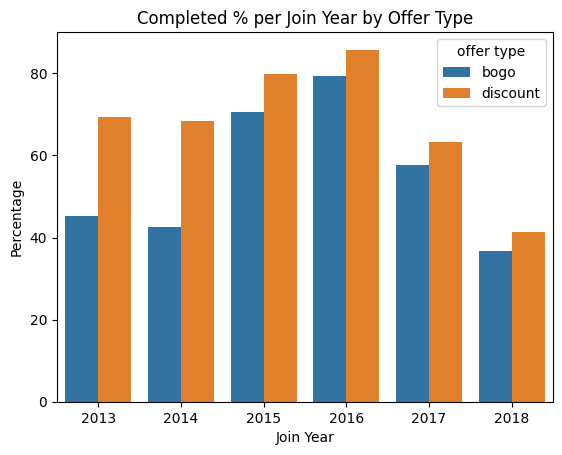

In [55]:
# Analyze offer completion rates by merging transaction data with demographic features
for feature in ['age_group', 'income_group', 'gender', 'year']:
    helper_df = pd.merge(transcript_eda, profile_eda[['id', feature]], left_on='person', right_on='id', how='left')
    helper_df = helper_df.query('event in ["offer received", "offer completed"] and offer_type != "informational"')

    # Create a pivot table to calculate completion rates
    helper_pivot_table = helper_df.pivot_table(
        index=[feature, 'offer_type'],
        columns='event',
        values='time',
        aggfunc='count',
        fill_value=0
    )
    helper_pivot_table['completion_rate'] = (helper_pivot_table['offer completed'] / helper_pivot_table['offer received']) * 100
    helper_pivot_table.reset_index(inplace=True)

    # Plot completion rates
    x_var_name = get_feature_name(feature)
    sns.barplot(x=feature, y='completion_rate', hue='offer_type', data=helper_pivot_table)
    plt.title(f'Completed % per {x_var_name} by Offer Type')
    plt.xlabel(x_var_name)
    plt.ylabel('Percentage')
    plt.legend(title='offer type')
    if x_var_name == 'Income Group':
        plt.xticks(rotation=30)
    plt.show()

Age Group Analysis:
- Completion rates increase along with the age of the customers.
- Customers show a preference for discount offers over bogo offers across all age groups. This preference is more significant in teens and young adults.
  
Income Group Analysis:
- Completion rates increase along with the income of the customers.
- Customers show a preference for discount offers across all income groups. This preference is more significant in the lower income ranges.
  
Gender Analysis:
- Female customers typically complete more offers than male, with a slight preference for discount offers.
- Male customers demonstrate a more noticeable preference for discount offers.
- Customers of 'Other' gender complete about as many offers as female customers, with no apparent preference for a specific type.

Join Year Analysis:
- The highest completion rates are demonstrated by customers who joined in 2015 and 2016.
- All year groups show a preference for completing discount offers. This preference is much more significant for customers who joined in 2013 and 2014.

**Completion Percentages by Gender Across Age and Income Groups**

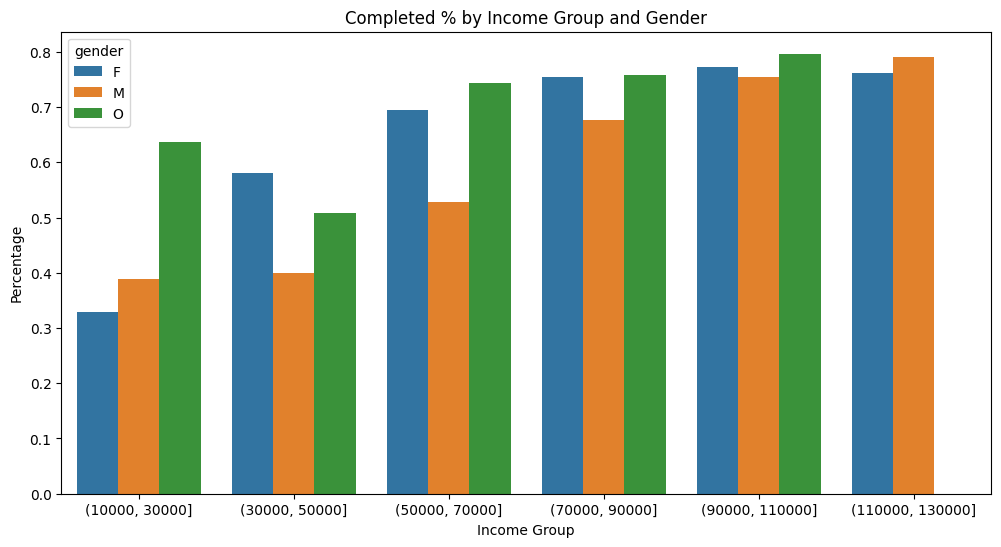

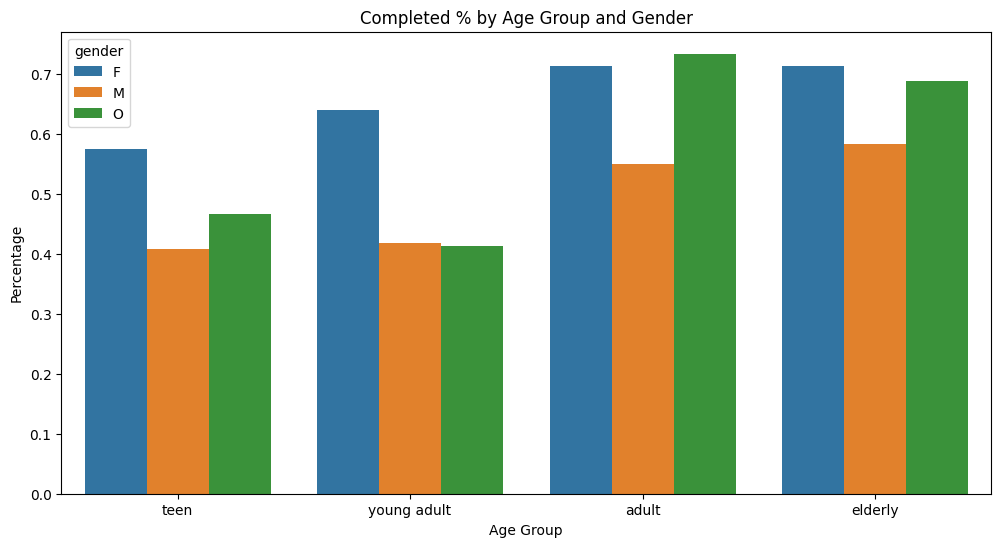

In [56]:
# Group data by gender and demographic features to analyze completion rates
gender_age = event_extended_df.groupby(["gender", "age_group"]).agg({"event_offer_completed":"sum", "event_offer_received":"sum"})
gender_income = event_extended_df.groupby(["gender", "income_group"]).agg({"event_offer_completed":"sum", "event_offer_received":"sum"})
gender_income.loc[:,"completion_%"] = gender_income.event_offer_completed/gender_income.event_offer_received
gender_age.loc[:,"completion_%"] = gender_age.event_offer_completed/gender_age.event_offer_received

# Plot completion rates by income group and gender
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "income_group", y = "completion_%", hue = "gender", data=gender_income.reset_index())
ax.set_xlabel("Income Group")
ax.set_ylabel("Percentage")
ax.set_title("Completed % by Income Group and Gender")
plt.show()

# Plot completion rates by age group and gender
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "age_group", y = "completion_%", hue = "gender", data=gender_age.reset_index())
ax.set_xlabel("Age Group")
ax.set_ylabel("Percentage")
ax.set_title("Completed % by Age Group and Gender")
plt.show()

Income Group and Gender Analysis:
- Females complete significantly more offers than males in the 30-70k range, slightly more than males in the 70-110k range, but slightly less in the <30k and >110k income groups.
- Customers of 'Other' gender show similar completion rates as females in the 50-110k income range, slightly lower completion rates than females in the 30-50k range, and significantly higher than females in the <30k income group.

Age Group and Gender Analysis:
- Females complete more offers than males across all age groups. 
- Customers of 'Other' gender show similar completion rates as females in the adult and elderly groups, but similar as males in the younger groups.

## Predictive Modelling

### Predicting Customer Expenses

The objective of this section is to predict average transaction size using demographic data. This involves preprocessing the data, exploring potential outliers, splitting the data into training and testing sets, and finally running regression models to predict the expenses.

**Data Preparation and Exploration**

In [57]:
# Copy the necessary columns for the regression analysis
data = profile[['age', 'income', 'member_days', 'gender', 'avg_transaction']].copy()

display(data)

,age,income,member_days,gender,avg_transaction
0,66.0,39000.0,566,F,2.266667
1,55.0,112000.0,413,F,25.670000
2,70.0,49000.0,51,M,2.383333
3,75.0,100000.0,480,F,22.752857
4,33.0,31000.0,393,M,1.550000
...,...,...,...,...,...
16995,45.0,54000.0,89,F,2.861429
16996,61.0,72000.0,50,M,3.710000
16997,49.0,73000.0,583,M,4.967500
16998,83.0,50000.0,908,F,13.547857


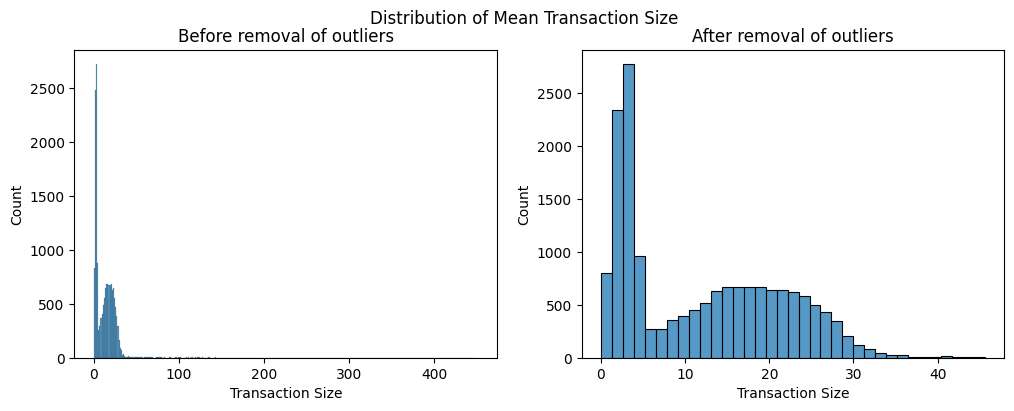

In [58]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Distribution of Mean Transaction Size')

# Initial visualization of the target variable
target_col = 'avg_transaction'
sns.histplot(data[target_col], kde=False, ax=ax0)
ax0.set_title('Before removal of outliers')
ax0.set_xlabel('Transaction Size')

# Identify and remove outliers using IQR
Q1 = data[target_col].quantile(0.25)
Q3 = data[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_cleaned = data[(data[target_col] >= lower_bound) & (data[target_col] <= upper_bound)].copy()

# Final visualization of the target variable
sns.histplot(data_cleaned[target_col], kde=False, ax=ax1)
ax1.set_title('After removal of outliers')
ax1.set_xlabel('Transaction Size')
plt.show()

**Data Splitting for Training & Testing**

This step ensures that the model will be trained and tested on a representative sample of the data, accounting for the distribution of the transaction sizes.

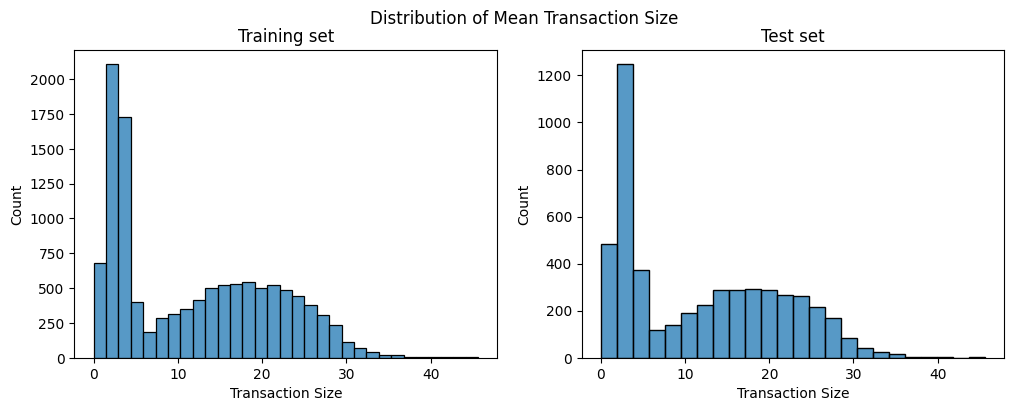

((11718, 4), (5022, 4))

In [60]:
# Split data into features and target variable
X = data_cleaned.drop(target_col, axis=1)
y = data_cleaned[target_col]

# Function to perform stratified split for regression data
def stratified_split_regression(X, y, bins=10, test_size=0.2, random_state=None):
    y_binned, bins = pd.qcut(y, q=bins, retbins=True, labels=False, duplicates='drop')
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Apply stratified splitting
X_train, X_test, y_train, y_test = stratified_split_regression(X, y, bins=20, test_size=0.3, random_state=0)

# Visualize the distribution of transaction sizes in the training and testing datasets
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Distribution of Mean Transaction Size')
sns.histplot(y_train, kde=False, ax=ax0)
ax0.set_title('Training set')
ax0.set_xlabel('Transaction Size')
sns.histplot(y_test, kde=False, ax=ax1)
ax1.set_title('Test set')
ax1.set_xlabel('Transaction Size')
plt.show()

# Display shapes to confirm split
X_train.shape, X_test.shape

**Model Training and Evaluation**

This section sets up various regression models to predict the average transaction size based on customer demographics, utilizing a robust preprocessing pipeline and hyperparameter tuning to optimize model performance. The results are evaluated using the RMSE metric to gauge the accuracy of predictions.

In [61]:
# Function to train multiple regression models and evaluate their performance
def run_regressors(X_train, X_test, y_train, y_test, numeric_features, categorical_features):
    # Set up preprocessing for numeric and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
        ]
    )
    
    # Define a dictionary of models with their instantiation and hyperparameter grid
    models_params = {
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'regressor__alpha': [0.1, 1, 10]
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [10, 20, None],
                'regressor__min_samples_split': [2, 5],
                'regressor__min_samples_leaf': [1, 2]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(objective='reg:squarederror', verbosity=0, silent=True),
            'params': {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [3, 5],
                'regressor__learning_rate': [0.01, 0.1]
            }
        },
        'LGBMRegressor': {
            'model': LGBMRegressor(verbose=0),
            'params': {
                'regressor__n_estimators': [100, 200],
                'regressor__num_leaves': [31, 50],
                'regressor__learning_rate': [0.01, 0.1]
            }
        }
    }
    
    # Prepare to collect results in a DataFrame
    results_df = pd.DataFrame(columns=['Model', 'BestEstimator', 'BestParams', 'RMSE', 'GridSearchTime'])
    
    # Iterate over each model in the dictionary
    for model_name, mp in models_params.items():
        print(model_name)

        # Create a pipeline that includes preprocessing and the regressor
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', mp['model'])])
        
        # Set up GridSearchCV to optimize model parameters
        grid_search = GridSearchCV(pipeline, mp['params'], cv=5, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error')
        
        # Fit the model
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        duration = end_time - start_time
        
        # Extract the best model from the grid search and calculate its RMSE
        best_model = grid_search.best_estimator_    
        y_pred = best_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"RMSE: {rmse}")
        
        # Append results to the DataFrame
        new_results_df = pd.DataFrame({
            'Model': model_name,
            'BestEstimator': best_model,
            'RMSE': rmse,
            'GridSearchTime': duration
        }, index=[0])
        results_df = pd.concat([results_df, new_results_df], ignore_index=True)
        
        # Inspect feature impact
        preprocessor = best_model.named_steps['preprocessor']
        model = best_model.named_steps['regressor']
        X_test_transformed = preprocessor.transform(X_test)
        if model_name in ['LinearRegression', 'Ridge']:
            shap_kernel = shap.LinearExplainer(model, X_test_transformed)
        else:
            shap_kernel = shap.TreeExplainer(model)
        feature_names = [s.split('__', 1)[1] if '__' in s else '' for s in preprocessor.get_feature_names_out()]
        shap_values = shap_kernel(pd.DataFrame(X_test_transformed, columns=feature_names))
        plt.title(model_name)
        shap.plots.beeswarm(shap_values)
    
    # Display the summarized results of all models
    display(results_df[['Model', 'RMSE', 'GridSearchTime']].set_index('Model'))

LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RMSE: 6.208741194530587


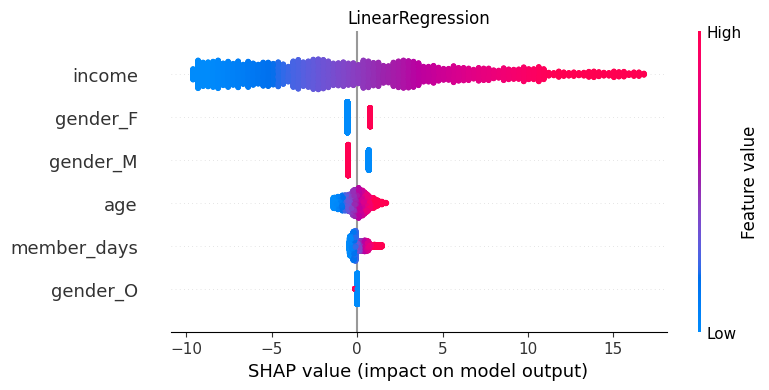

Ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
RMSE: 6.208777225671813


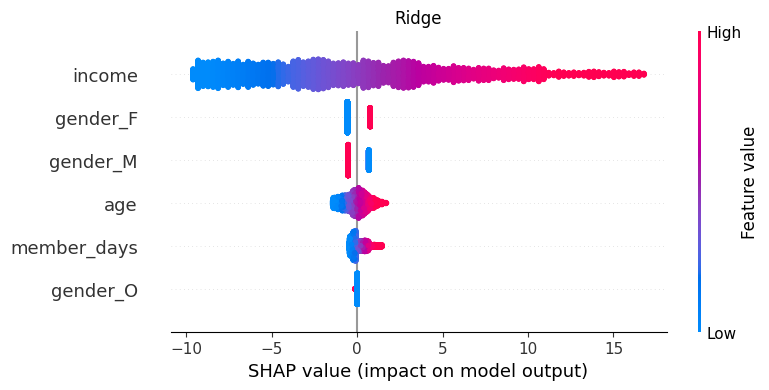

RandomForestRegressor
Fitting 5 folds for each of 24 candidates, totalling 120 fits


RMSE: 5.896571700102807


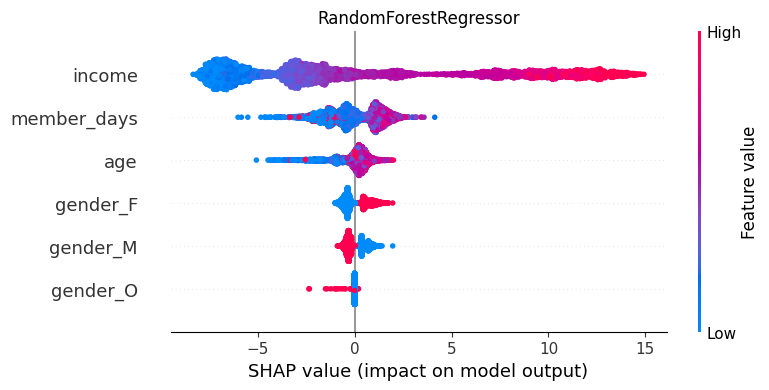

XGBRegressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RMSE: 5.807887542270111


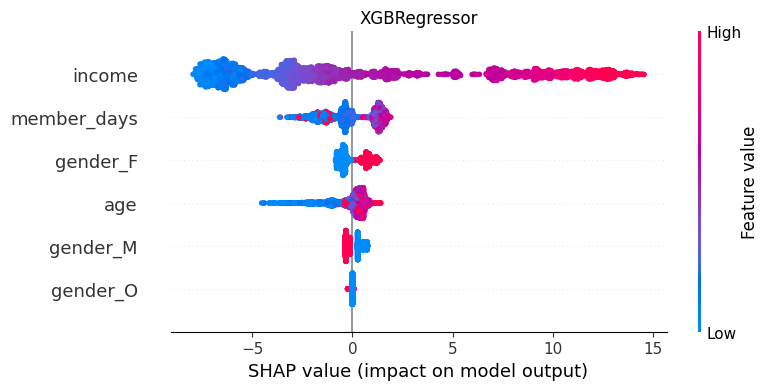

LGBMRegressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RMSE: 5.8571436430556485


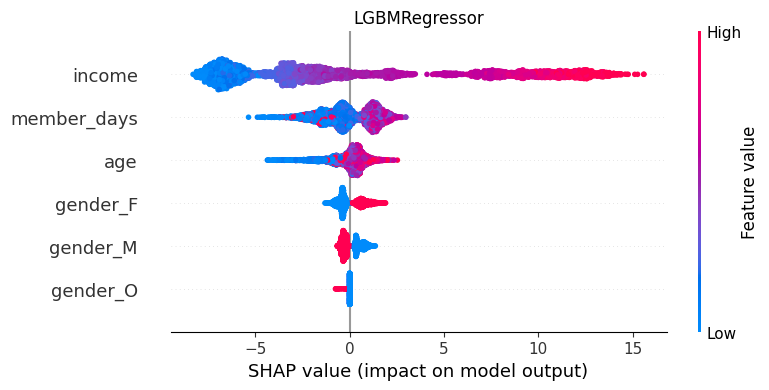

,RMSE,GridSearchTime
Model,,
LinearRegression,6.208741,0.669555
Ridge,6.208777,0.620533
RandomForestRegressor,5.896572,19.180290
XGBRegressor,5.807888,2.152365
LGBMRegressor,5.857144,18.910115


In [62]:
# Invoke the function to run the regressors
run_regressors(
    X_train, 
    X_test,
    y_train, 
    y_test, 
    ['age', 'income', 'member_days'],
    ['gender'],
)

**Model Choice**

- The **XGBRegressor** achieves the lowest RMSE (5.808) with a relatively lower computation time compared to the RandomForest and LGBM regressors, making it an attractive choice for both performance and efficiency.
- **RandomForestRegressor** and **LGBMRegressor** also perform well but at a significantly higher computational cost.

**Insights from SHAP Values**

SHAP values help us understand the influence of each feature on a model's output. Here are the key insights from the SHAP analyses:

- **Income**:
  - **Overall Influence**: Across all models, income remains the most consistently high-impact predictor. A higher income seems to contribute to predicting larger transaction sizes.
  - **Model Variability**: The influence of income is uniformly strong in linear models and shows slightly more variability in tree-based models.

- **Membership Days**:
  - **Overall Influence**: Higher membership duration tends to increase the predicted transaction sizes.
  - **Model Variability**: In the linear models, membership duration exhibits a more concentrated cluster around the mean, indicating a moderate influence. In contrast, the tree-based models display wider spreads, suggesting greater influence, possibly due to capturing more complex interactions or non-linear effects.

- **Age**:
  - **Overall Influence**: Age positively influences transaction size predictions across all models.
  - **Model Variability**: The effect of age is relatively muted in linear models compared to tree-based models, where its impact appears with greater variability, highlighting the non-linear relationships captured by these models.

- **Gender**:
  - **Overall Influence**: The female category seems to contribute positively to the predicted values, while the impact of the male category is less positive. The 'Other' gender category has less influence, possibly due to fewer data points.
  - **Model Variability**: There is noticeable variability in how gender categories are treated across different models. In tree-based models, the impact of gender shows more pronounced fluctuation, reflecting diverse interactions with other features or inherent biases within the data towards gender-based spending behaviors.

### Predicting Offer Views

This section focuses on predicting whether a customer will view an offer based on their demographic profile and the distribution channels used. This kind of predictive modeling is crucial for optimizing marketing strategies by targeting the right audience with the right offers through the most effective channels.

**Data Preparation and Exploration**

In [57]:
# Merge demographic data with offer view data and offer channel information
data = profile[['age', 'income', 'member_days', 'gender', 'id']]
data = data.merge(responses[['person', 'offer_id', 'time_viewed']], left_on='id', right_on='person')
channel_columns = ['channel_email', 'channel_mobile', 'channel_social', 'channel_web']
data = data.merge(portfolio[['offer_id', *channel_columns]], on='offer_id')

# Create a binary target variable for whether the offer was viewed
data['viewed'] = data['time_viewed'].apply(lambda x: 1 if pd.notna(x) else 0)
target_names = ['Not Viewed', 'Viewed']

# Prepare final dataset for modelling
data = data[['age', 'income', 'member_days', 'gender', *channel_columns, 'viewed']]
data.drop('channel_email', axis=1, inplace=True)  # redundant since email was used for all offers

display(data)

,age,income,member_days,gender,channel_mobile,channel_social,channel_web,viewed
0,66.0,39000.0,566,F,0,0,1,1
1,66.0,39000.0,566,F,1,1,1,1
2,66.0,39000.0,566,F,1,1,1,1
3,66.0,39000.0,566,F,1,1,1,1
4,66.0,39000.0,566,F,1,0,1,1
...,...,...,...,...,...,...,...,...
76272,83.0,50000.0,908,F,1,0,1,1
76273,62.0,82000.0,406,F,1,1,1,1
76274,62.0,82000.0,406,F,1,1,1,1
76275,62.0,82000.0,406,F,1,0,1,0


**Data Splitting for Training & Testing**

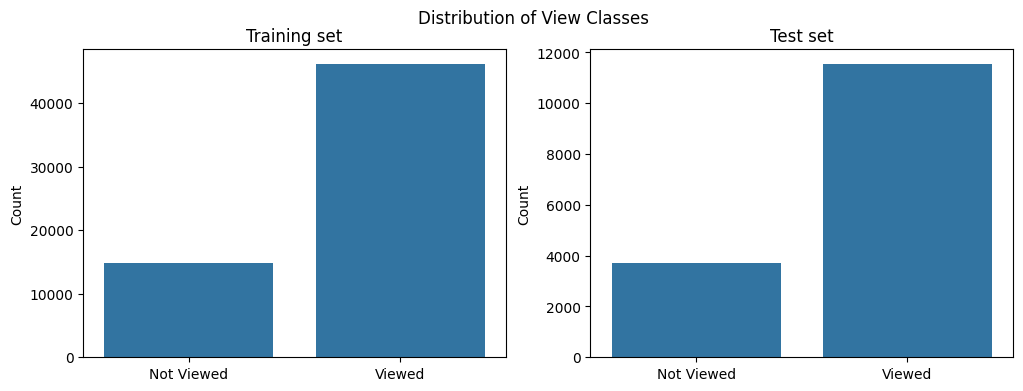

((61021, 7), (15256, 7))

In [58]:
# Separate features and target variable
X = data.drop(['viewed'], axis=1)
y = data['viewed']

# Perform a stratified split to ensure class proportionality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Visualize the distribution of the target classes in training and test sets
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Distribution of View Classes')
sns.countplot(x=y_train, ax=ax0)
ax0.set_title('Training set')
sns.countplot(x=y_test, ax=ax1)
ax1.set_title('Test set')
for ax in [ax0, ax1]:
    ax.set_xlabel('')
    tick_positions = ax.get_xticks()
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Count')
plt.show()

# Display shapes to confirm split
X_train.shape, X_test.shape

**Model Training and Evaluation**

In [60]:
# Function to run multiple classifiers and evaluate their performance
def run_classifiers(X_train, X_test, y_train, y_test, numeric_features, categorical_features, pass_features=None):
    # Set up preprocessing for numeric and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
            ("other", "passthrough", pass_features),
        ])

    # Define a dictionary of models with their instantiation and hyperparameter grid
    models_params = {
        'LogisticRegression': {
            'model': LogisticRegression(class_weight='balanced', max_iter=2000),
            'params': {
                'classifier__C': [0.01, 0.1, 1, 10, 100],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear', 'saga']
            }
        },
        'RandomForestClassifier': {
            'model': RandomForestClassifier(class_weight='balanced'),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [10, 20, 30, None],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]
            }
        },
        'XGBClassifier': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [3, 5, 7],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__subsample': [0.7, 0.9],
                'classifier__colsample_bytree': [0.7, 0.9]
            }
        },
        'LGBMClassifier': {
            'model': LGBMClassifier(verbose=-1, is_unbalance=True),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__num_leaves': [31, 50, 70],
                'classifier__learning_rate': [0.01, 0.05, 0.1],
                'classifier__boosting_type': ['gbdt', 'dart']
            }
        },
    }

    # Prepare to collect results in a Dataframe
    results_df = pd.DataFrame(columns=['Model', 'BestEstimator', 'BestParams', 'macroF1', 'GridSearchTime'])

    # Iterate over each model in the dictionary
    for model_name, mp in models_params.items():
        print(model_name)

        # Create a pipeline that includes preprocessing and the classifier
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', mp['model'])])
        grid_search = GridSearchCV(pipeline, mp['params'], cv=5, verbose=1, n_jobs=-1, scoring='f1_macro')
        
        # Fit the model
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        duration = end_time - start_time
        
        # Extract the best model from the grid search and evaluate it
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        y_pred = best_model.predict(X_test)    
        print(classification_report(y_test, y_pred, target_names=target_names))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(model_name)
        plt.show()

        # Append results to the DataFrame
        new_results_df = pd.DataFrame({
            'Model': model_name,
            'BestEstimator': best_model,
            'macroF1': best_score,
            'GridSearchTime': duration
        }, index=[0])
        results_df = pd.concat([results_df, new_results_df], ignore_index=True)   

        # Inspect feature impact
        preprocessor = best_model.named_steps['preprocessor']
        model = best_model.named_steps['classifier']
        X_test_transformed = preprocessor.transform(X_test)
        if model_name in ['LogisticRegression']:
            shap_kernel = shap.LinearExplainer(model, X_test_transformed)
        else:
            shap_kernel = shap.TreeExplainer(model)
        feature_names = [s.split('__', 1)[1] if '__' in s else '' for s in preprocessor.get_feature_names_out()]
        shap_values = shap_kernel(pd.DataFrame(X_test_transformed, columns=feature_names))
        if len(shap_values.shape) == 3:
            shap_values = shap_values[..., 0]
        plt.title(model_name)
        shap.plots.beeswarm(shap_values)

    # Display the summarized results of all models
    display(results_df[['Model', 'macroF1', 'GridSearchTime']].set_index('Model'))

LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

  Not Viewed       0.51      0.83      0.63      3711
      Viewed       0.93      0.75      0.83     11545

    accuracy                           0.77     15256
   macro avg       0.72      0.79      0.73     15256
weighted avg       0.83      0.77      0.78     15256



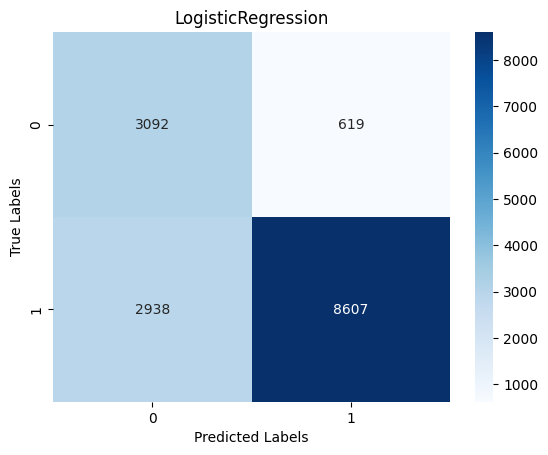

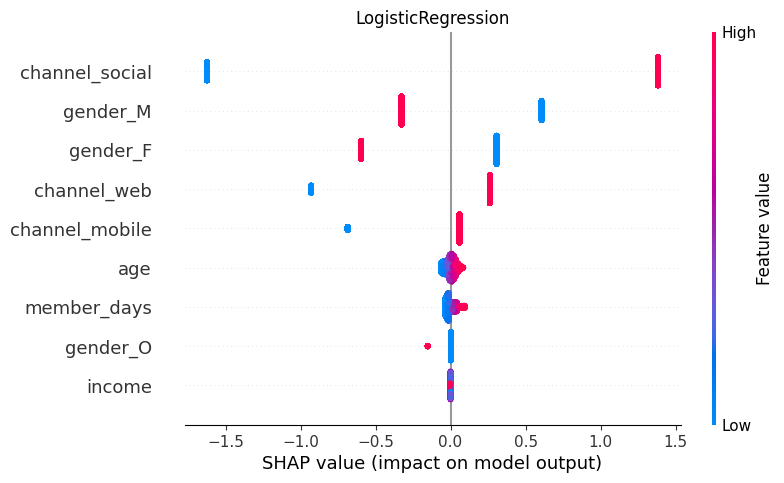

RandomForestClassifier
Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

  Not Viewed       0.59      0.76      0.66      3711
      Viewed       0.91      0.83      0.87     11545

    accuracy                           0.81     15256
   macro avg       0.75      0.79      0.77     15256
weighted avg       0.84      0.81      0.82     15256



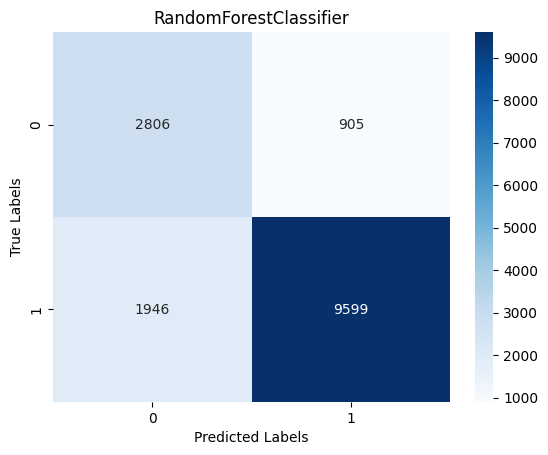

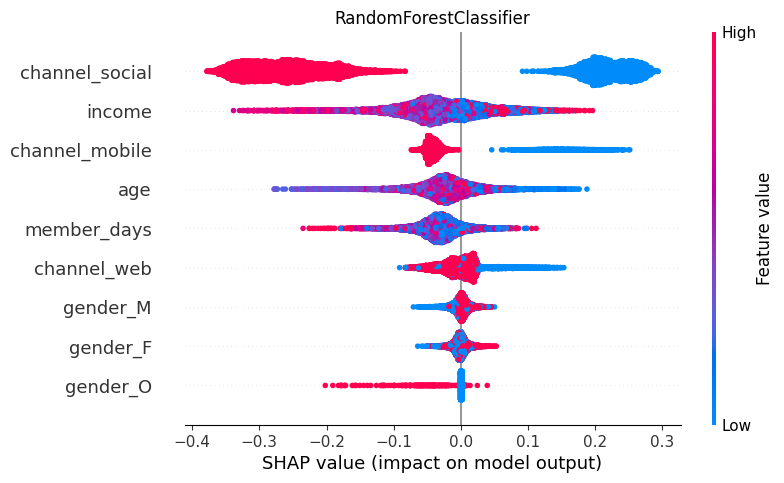

XGBClassifier
Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

  Not Viewed       0.76      0.26      0.39      3711
      Viewed       0.80      0.97      0.88     11545

    accuracy                           0.80     15256
   macro avg       0.78      0.62      0.63     15256
weighted avg       0.79      0.80      0.76     15256



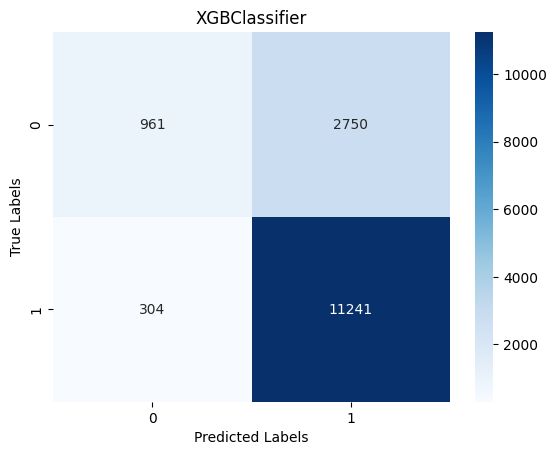

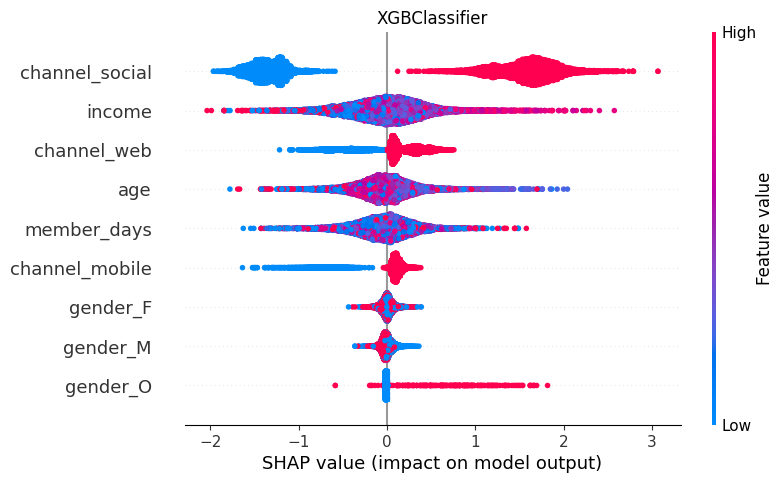

LGBMClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

  Not Viewed       0.59      0.74      0.65      3711
      Viewed       0.91      0.83      0.87     11545

    accuracy                           0.81     15256
   macro avg       0.75      0.78      0.76     15256
weighted avg       0.83      0.81      0.82     15256



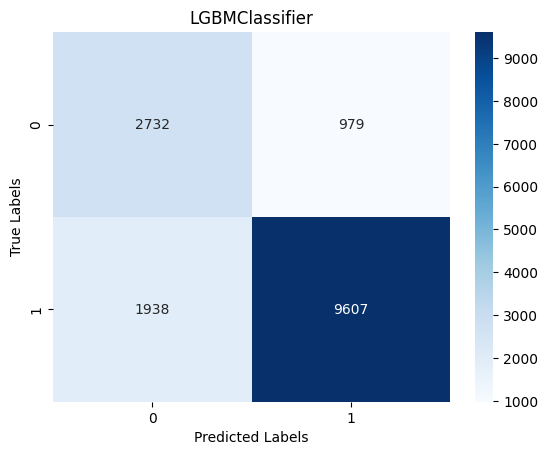

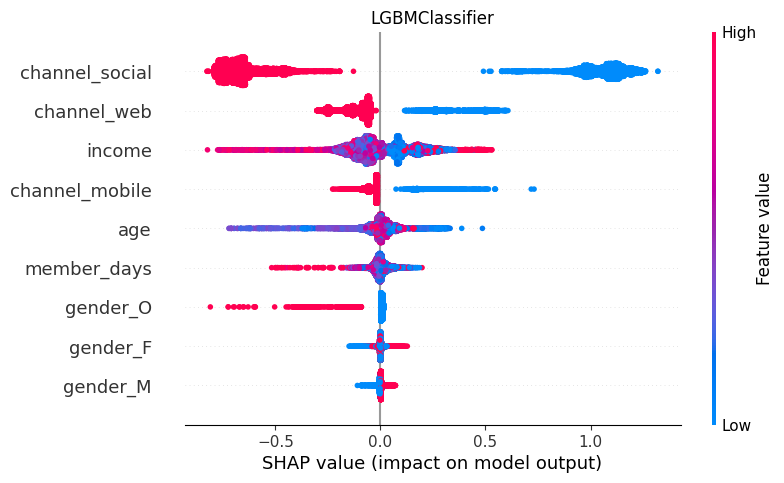

,macroF1,GridSearchTime
Model,,
LogisticRegression,0.726553,15.360575
RandomForestClassifier,0.757269,137.319115
XGBClassifier,0.624688,19.334957
LGBMClassifier,0.753127,151.921772


In [61]:
# Invoke the function to run the classifiers
run_classifiers(
    X_train, 
    X_test,
    y_train, 
    y_test, 
    ['age', 'income', 'member_days'],
    ['gender'],
    pass_features=['channel_mobile', 'channel_social', 'channel_web']
)

The classifiers used are assessed based on their precision, recall, f1-score, and macro F1 score across the two classes: 'Not Viewed' and 'Viewed'. The accuracy and the confusion matrix also provide insight into each model's performance.

These are the key takeaways from each classifier:
- **Logistic Regression**:
  - Achieved moderate precision and high recall for the 'Not Viewed' class, indicating that it can identify a large portion of the actual non-viewed offers.
  - The high recall and lower precision for 'Viewed' offers suggest some false positives, where offers are predicted as viewed but aren't actually viewed.
  - The overall macro f1-score is fairly good, balancing the trade-off between recall and precision.
- **Random Forest Classifier**:
  - Exhibited improved performance over Logistic Regression in both precision and recall for the 'Not Viewed' class.
  - Achieved high precision but slightly lower recall for 'Viewed', indicating fewer false positives but missing some true positives.
  - The overall macro f1-score suggests a balanced performance, making it a robust choice for this prediction task.
- **XGBClassifier**:
  - Showed a discrepancy between high precision and low recall for the 'Not Viewed' class, indicating it is conservative in predicting this class but misses a significant number of true 'Not Viewed' cases.
  - High precision and recall for 'Viewed' means it effectively identifies most viewed offers but with some false positives.
  - The lower macro f1-score compared to other models reflects the significant trade-off in performance between the two classes.
- **LGBMClassifier**:
  - Similar to Random Forest, it shows strong performance but with a trade-off between precision and recall across both classes.
  - It manages to achieve a high weighted average for accuracy and f1-score, indicating a good balance in handling both classes.


**Model Choice**

Overall, the choice of classifier can be optimized based on the trade-off between computational efficiency and prediction accuracy. The RandomForest and LGBM classifiers provide a good balance but at a higher computational cost, while Logistic Regression offers a quick but less nuanced understanding of feature impacts.

**Insights from SHAP Values**

When comparing SHAP values across different classifiers, it's important to consider how these values are calculated and presented for each model. For the RandomClassifier, SHAP values are provided for each class separately, and we have visualized the ones relevant to class 0. However, for other models, SHAP values are provided for a single class, potentially class 1. This discrepancy means that feature impacts may appear reversed between different model plots. Keeping this in mind, here are the main insights from the SHAP analyses:

- **Channel Social**:
  - **Overall Influence**: The 'social' channel has a positive influence on predicting offer views.
  - **Model Variability**: Its positive impact is consistent across models, though the magnitude of the impact varies slightly, suggesting a robust association across different predictive approaches.

- **Channel Mobile**:
  - **Overall Influence**: The 'mobile' channel also shows a positive effect across all models.
  - **Model Variability**: Its impact is more prominent in tree-based models like the RandomForestClassifier and XGBClassifier.

- **Channel Web**:
  - **Overall Influence**: The 'web' channel generally seems to have a positive effect on predicting views.
  - **Model Variability**: Its influence varies significantly across models, indicating that it might be more context-dependent or influenced by interactions with other features.

- **Membership Days**:
  - **Overall Influence**: Membership duration shows a mixed impact, sometimes positive and sometimes negative, suggesting that its effectiveness might depend on other factors.
  - **Model Variability**: The strength of its effect varies across models.

- **Income**:
  - **Overall Influence**: Income generally shows a neutral to positive influence on the likelihood of viewing offers.
  - **Model Variability**: The positive impact of income is not consistent across models, with some showing a strong positive influence and others showing minimal impact, suggesting that the effect of income may interact complexly with other factors.

- **Age**:
  - **Overall Influence**: Age has a mixed influence across models, with no clear trend suggesting a direct relationship between age and the likelihood of viewing offers.
  - **Model Variability**: Age shows variable effects across different models, from slight negative to minimal impact, suggesting that age alone is not a strong predictor and its effect may be modulated by other demographic or behavioral factors.

- **Gender**:
  - **Overall Influence**: Gender variations have diverse impacts. The female and male gender groups show a tendency to positively affect the view prediction, in contrast to the 'Other' group. 
  - **Model Variability**: Gender group impacts vary across models, with some showing significant effects for different genders and others showing negligible differences. This indicates that the role of gender in predicting offer views might depend heavily on the model context or feature interactions.

### Predicting Offer Effectiveness

This section focuses on predicting the effectiveness of offers based on the combination of customer demographics and offer characteristics. An offer is considered "effective" if a customer completes it after viewing it, thus indicating that the offer was instrumental in influencing the customer's purchasing decision.

**Data Preparation and Exploration**

In [64]:
# Merge responses with customer profiles and offer details
data = pd.merge(responses, profile, left_on='person', right_on='id', how='left').drop('id', axis=1)
data = pd.merge(data, portfolio[['offer_id', 'reward', *channel_columns]], on='offer_id', how='left')
data = data.query('offer_type != "informational"')

# Function to label each response as effective or not
def label_effective(row):
    if pd.notna(row['time_completed']) and row['time_viewed'] < row['time_completed']:
        return 1   # Effective if viewed and then completed
    return 0   # Not effective otherwise (either no completion or accidental completion)

# Apply the labeling function to generate the target variable
data['effective'] = data.apply(lambda x: label_effective(x), axis=1)
target_names = ['Not Effective', 'Effective']

# Prepare final dataset for modelling
data = data[['age', 'income', 'member_days', 'gender', 'offer_type', 'reward', 'difficulty', 'duration', 'effective']]

display(data)

,age,income,member_days,gender,offer_type,reward,difficulty,duration,effective
0,33.0,72000.0,498,M,bogo,5,5.0,5.0,0
1,33.0,72000.0,498,M,discount,2,10.0,10.0,0
2,33.0,72000.0,498,M,discount,2,10.0,7.0,0
5,67.0,38000.0,129,M,bogo,5,5.0,5.0,0
6,67.0,38000.0,129,M,bogo,5,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...
76272,45.0,62000.0,645,F,discount,5,20.0,10.0,1
76273,45.0,62000.0,645,F,discount,2,10.0,10.0,1
76274,45.0,62000.0,645,F,discount,2,10.0,7.0,1
76275,45.0,62000.0,645,F,discount,2,10.0,7.0,0


**Splitting Data for Training & Testing**

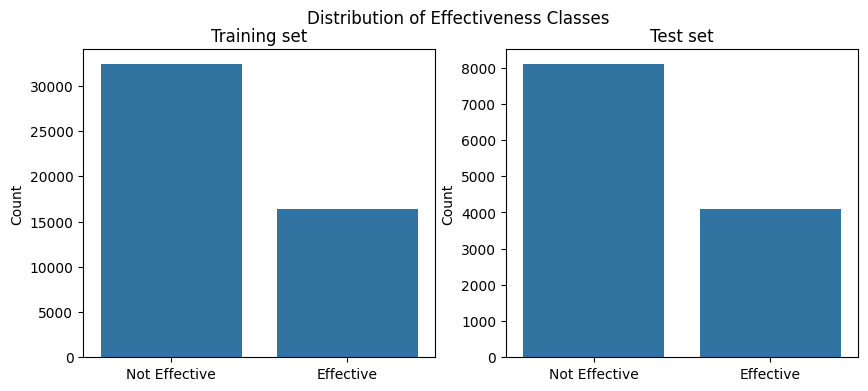

((48833, 8), (12209, 8))

In [66]:
# Separate features and target variable
X = data.drop(['effective'], axis=1)
y = data['effective']

# Perform a stratified split to ensure class proportionality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Visualize the distribution of the target classes in training and test sets
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribution of Effectiveness Classes')
sns.countplot(x=y_train, ax=ax0)
ax0.set_title('Training set')
sns.countplot(x=y_test, ax=ax1)
ax1.set_title('Test set')
for ax in [ax0, ax1]:
    ax.set_xlabel('')
    tick_positions = ax.get_xticks()
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Count')
plt.show()

# Display shapes to confirm split
X_train.shape, X_test.shape

**Model Training and Evaluation**

LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
               precision    recall  f1-score   support

Not Effective       0.75      0.62      0.68      8103
    Effective       0.44      0.59      0.50      4106

     accuracy                           0.61     12209
    macro avg       0.59      0.60      0.59     12209
 weighted avg       0.64      0.61      0.62     12209



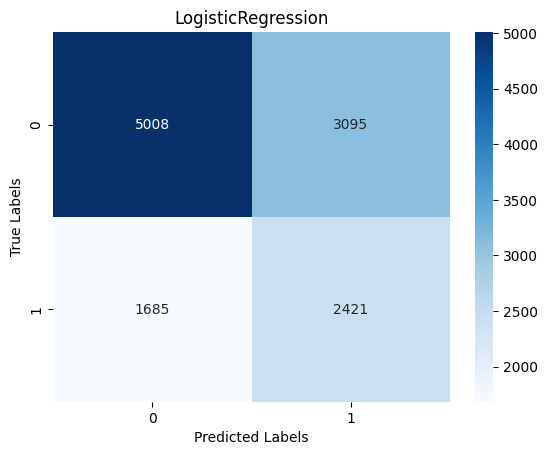

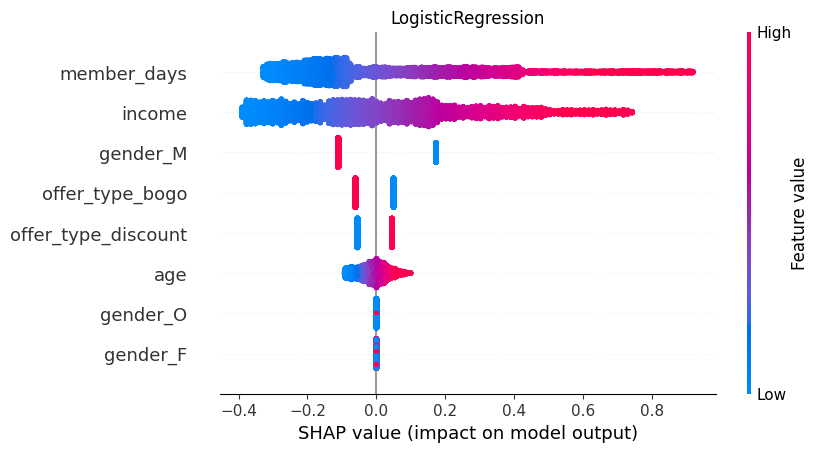

RandomForestClassifier
Fitting 5 folds for each of 72 candidates, totalling 360 fits
               precision    recall  f1-score   support

Not Effective       0.75      0.68      0.71      8103
    Effective       0.47      0.56      0.51      4106

     accuracy                           0.64     12209
    macro avg       0.61      0.62      0.61     12209
 weighted avg       0.65      0.64      0.64     12209



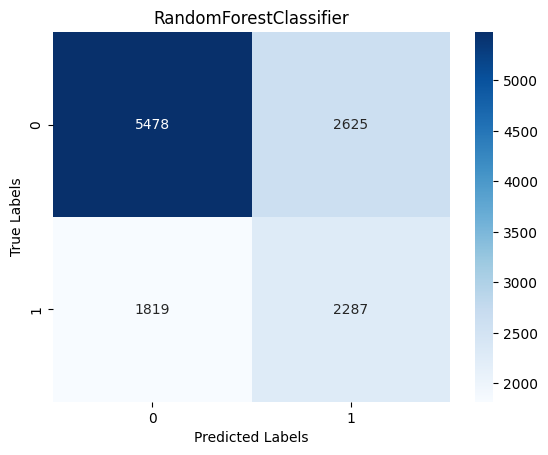

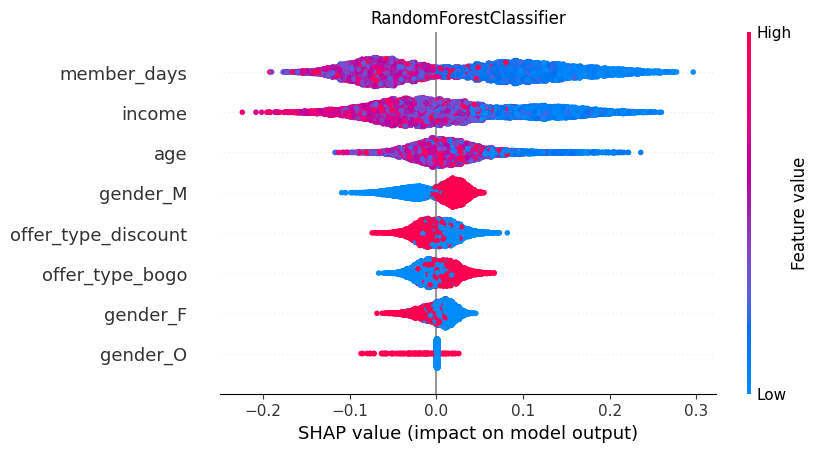

XGBClassifier
Fitting 5 folds for each of 72 candidates, totalling 360 fits
               precision    recall  f1-score   support

Not Effective       0.80      0.49      0.61      8103
    Effective       0.43      0.76      0.55      4106

     accuracy                           0.58     12209
    macro avg       0.62      0.63      0.58     12209
 weighted avg       0.68      0.58      0.59     12209



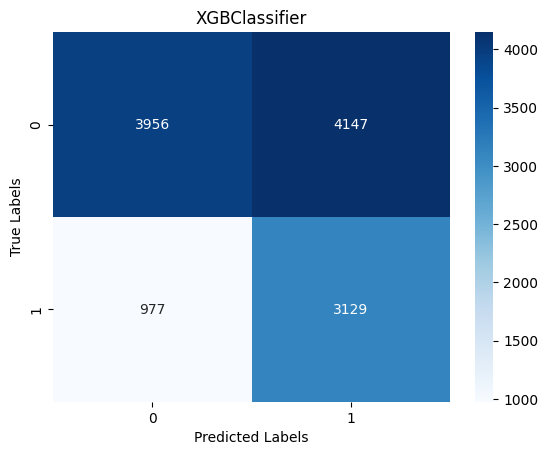

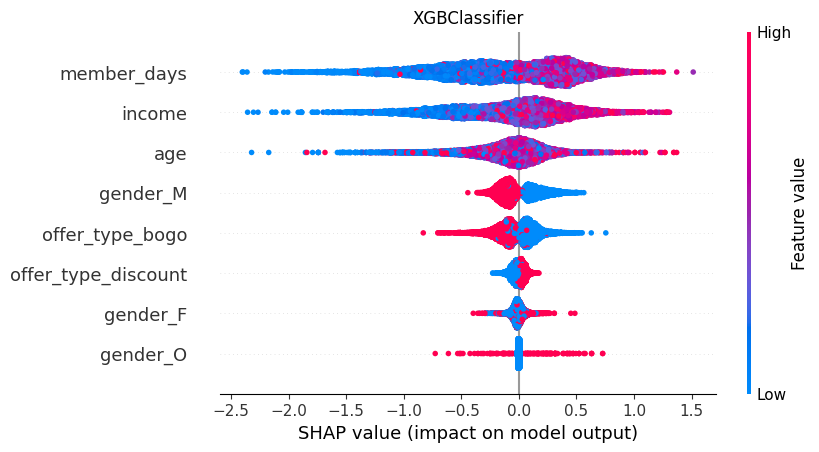

LGBMClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits
               precision    recall  f1-score   support

Not Effective       0.77      0.60      0.68      8103
    Effective       0.45      0.65      0.53      4106

     accuracy                           0.62     12209
    macro avg       0.61      0.63      0.61     12209
 weighted avg       0.67      0.62      0.63     12209



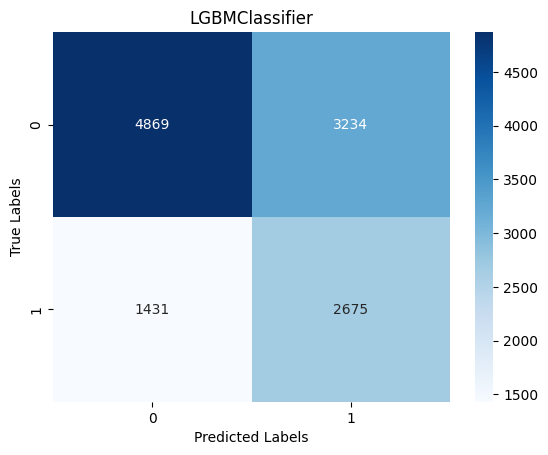

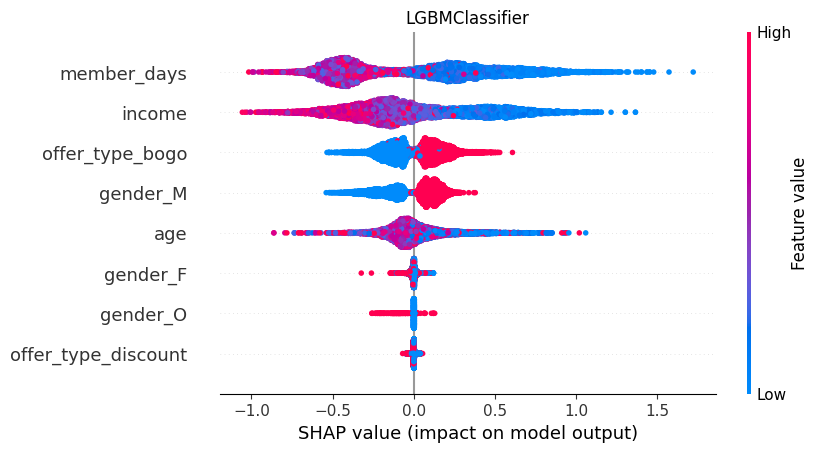

,macroF1,GridSearchTime
Model,,
LogisticRegression,0.586349,6.017272
RandomForestClassifier,0.612877,139.593799
XGBClassifier,0.582062,16.519043
LGBMClassifier,0.611893,164.525639


In [67]:
# Invoke the function to run the classifiers
run_classifiers(
    X_train, 
    X_test,
    y_train, 
    y_test, 
    ['age', 'income', 'member_days'],
    ['gender', 'offer_type'],
)

These are the key takeaways from each classifier:

- **Logistic Regression**:
  - **Performance**: Moderate precision and recall, particularly for the 'Not Effective' class.
  - **Macro F1-Score**: 0.59, indicating a fair balance between precision and recall across classes but room for improvement.
  - **Observations**: It has a relatively low recall for the 'Effective' class, suggesting it often misses identifying truly effective offers.

- **Random Forest Classifier**:
  - **Performance**: Shows improvement in precision for both classes over Logistic Regression.
  - **Macro F1-Score**: 0.61, a slight improvement, indicating better handling of the class imbalance.
  - **Observations**: Better at handling the 'Effective' class than Logistic Regression, but still has a significant number of false negatives.

- **XGB Classifier**:
  - **Performance**: Notably higher recall for the 'Effective' class at the expense of precision, indicating it labels many offers as effective that are not.
  - **Macro F1-Score**: 0.58, slightly lower due to the trade-off between high recall and lower precision.
  - **Observations**: This model is useful if the cost of missing an effective offer is high, but it may waste resources by targeting too many non-effective offers.

- **LGBM Classifier**:
  - **Performance**: Similar to Random Forest in precision and recall but with a slightly higher recall for the 'Effective' class.
  - **Macro F1-Score**: 0.61, mirroring Random Forest in balancing precision and recall.
  - **Observations**: This model presents a balanced approach but still struggles with a high number of false positives and negatives.

**Model Choice**

- **Efficiency**: Logistic Regression is the most time-efficient, significantly faster than the tree-based models.
- **Resource Intensiveness**: Both LGBM and Random Forest classifiers require much longer times, indicative of their complexity and the depth of search required to optimize parameters.
- **Trade-offs**: Each model has trade-offs between identifying true positives and avoiding false positives. The choice of model could depend on the specific cost implications associated with false positives versus false negatives in a business context.
- **Model Selection**: For faster iteration and model development, Logistic Regression offers a good starting point. However, for potentially higher accuracy and better handling of imbalanced classes, tree-based models, despite their longer training times, might be preferable.

**Insights from SHAP Values**

These are the main insights from the SHAP analyses:

- **Membership Days**:
   - **Overall Influence**: Greater membership duration generally contributes to predicting higher offer effectiveness across all models.
   - **Model Variability**: This effect is most pronounced in the XGBClassifier and LGBMClassifier.

- **Income**:
   - **Overall Influence**: Higher income levels also consistently contribute to predicting higher effectiveness.
   - **Model Variability**: This influence is especially strong in the XGBClassifier and Logistic Regression.

- **Age**:
   - **Overall Influence**: Age shows a moderate positive influence, particularly in Random Forest and LGBMClassifier models.
   - **Model Variability**: Its impact is less consistent across models, suggesting that age may interact with other features to influence effectiveness.

- **Gender**:
   - **Male (Gender_M)**: Generally shows a slight positive influence on effectiveness predictions in most models.
   - **Female (Gender_F)**: Tends to have a variable impact; in some models like the XGBClassifier, it significantly increases the likelihood of predicting effectiveness.
   - **Other (Gender_O)**: Shows the most variability, with significant positive or negative shifts depending on the model, indicating uncertainty or inconsistent patterns in how offers affect individuals of 'Other' gender.

- **Offer Type**:
   - **BOGO**: Consistently shown across all models to have a strong positive influence on predicting effectiveness.
   - **Discount**: The impact of discount offers is more varied but generally shows a positive effect, though typically less so than BOGO offers.

### Improvement Suggestions 

- **Feature Engineering**: Incorporating additional features relevant to spending behavior, such as the previous transaction history of each customer, might provide more predictive power.

- **Temporal Dynamics**: Incorporating the timing of offers (e.g., day of the week) could also increase the predictive power.

- **Segmentation**: Instead of global models, segment-based models tailored to specific groups (e.g., based on demographics or previous purchasing behavior) might improve performance.

- **Balancing Classes**: Techniques like SMOTE for oversampling minority classes, or more sophisticated ensemble methods that handle imbalance intrinsically, could be explored.

- **Model Exploration**: Experimenting with neural networks or deep learning models could capture complex patterns that traditional models might have missed.

- **Hyperparameter Tuning**: While some basic tuning was done, a more exhaustive Grid Search, or more sophisticated strategies like Bayesian Optimization or Genetic Algorithms, might uncover better parameters for the models.

## Conclusion

This project has provided a thorough examination of customer behavior and response to marketing strategies through a detailed analysis of a rich dataset, which includes customer demographics, offer details, and transactional data. We segmented our efforts into three main sections: Data Processing, Exploratory Analysis, and Predictive Modelling, each contributing uniquely to our understanding and capabilities in predicting and influencing customer behavior.

**Overview of the Project Sections**
- **Data Processing**: We focused on preparing the data for analysis, which involved cleaning, handling missing values, and deriving new features. This stage was crucial for ensuring the quality and reliability of our subsequent analyses and model predictions.
- **Exploratory Analysis**: In this phase, we delved deep into the data to uncover underlying patterns and relationships. We visualized various aspects of the data, such as transaction distributions, offer responses, and demographic insights, which helped in understanding the dynamics influencing customer behavior and the effectiveness of the marketing offers.
- **Predictive Modelling**: This segment was divided into three subsections—predicting customer expenses, predicting offer views, and predicting offer effectiveness. We employed a range of statistical and machine learning techniques, from regression models to classifiers, to forecast customer behavior. Each model provided insights into different facets of customer interactions with the marketing efforts, highlighting the complexity and multi-dimensional nature of customer engagement.